# H1N1 Vaccine Model Analysis

### Introduction

######  Background: 
There have been several deadly pandemics throughout history, the topic of this project being the flu. According to the CDC, the flu is a contagious respiratory illness caused by influenza viruses. The H1N1 strain (also known as swine flu) was the cause of the 2009 pandemic, affecting millions worldwide. Significant efforts have since been made to develop and distribute vaccines to protect against this strain. 

###### Business Problem: 
We are tasked with predicting whether someone has recieved the H1N1 or seasonal flu vaccine; we will focus only on H1N1. We will do this by analyzing the data and the relationships between variables, and building several predictive models. Our goal is to help the stakeholders understand the distribution of vaccinations to help provide guidance for any future public health outbreaks/concerns. 

###### Stakeholders: 
We are presenting to a public health official/organization (such as the leadership team of the CDC). 

###### Please note: 
This is notebook 2 of 2. Please take a look at the General EDA notebook for an exploration of the data, summary statistics, the relationships between the variables, and an explanation of how I chose to focus on H1N1 over seasonal flu. 

Let's start with our imports, and then load in the data. I pulled the datasets from the competition website, linked here: https://www.drivendata.org/competitions/66/flu-shot-learning/data/. 

This dataset contains nearly 27,000 survey results. This is a very suitable dataset for this project as it contains a multitude of different survey results that we could use to make predictions. It's also a big enough size to conduct a successful train-test-split. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, PolynomialFeatures

from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.compose import ColumnTransformer,  make_column_selector as selector
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score

from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline
from sklearn.metrics import roc_auc_score, plot_roc_curve
from sklearn.metrics import classification_report

In [2]:
# load in the training set features file, set the index column equal to respondent id.
training_features = pd.read_csv('Data/training_set_features.csv', index_col='respondent_id')
training_features.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


In [3]:
# load in the training set labels file, set the index column equal to respondent id.
training_labels = pd.read_csv('Data/training_set_labels.csv', index_col='respondent_id')
training_labels.head()

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
0,0,0
1,0,1
2,0,0
3,0,1
4,0,0


In [4]:
training_features.shape

(26707, 35)

In [5]:
training_labels.shape

(26707, 2)

I remember from my data analysis that hhs_geo_region, employment_industry, and employment_occupation are random strings (probably for privacy reasons). I don't see how I am going to be able to use these as I can't make sense of them, so I am going to drop them. 

In [6]:
training_features[['hhs_geo_region', 'employment_industry', 'employment_occupation']].head()

,hhs_geo_region,employment_industry,employment_occupation
respondent_id,,,
0,oxchjgsf,NaN,NaN
1,bhuqouqj,pxcmvdjn,xgwztkwe
2,qufhixun,rucpziij,xtkaffoo
3,lrircsnp,NaN,NaN
4,qufhixun,wxleyezf,emcorrxb


In [7]:
training_features.drop(columns=['hhs_geo_region', 'employment_industry', 'employment_occupation'], axis=1, inplace=True)

In [8]:
training_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 26615 non-null  float64
 1   h1n1_knowledge               26591 non-null  float64
 2   behavioral_antiviral_meds    26636 non-null  float64
 3   behavioral_avoidance         26499 non-null  float64
 4   behavioral_face_mask         26688 non-null  float64
 5   behavioral_wash_hands        26665 non-null  float64
 6   behavioral_large_gatherings  26620 non-null  float64
 7   behavioral_outside_home      26625 non-null  float64
 8   behavioral_touch_face        26579 non-null  float64
 9   doctor_recc_h1n1             24547 non-null  float64
 10  doctor_recc_seasonal         24547 non-null  float64
 11  chronic_med_condition        25736 non-null  float64
 12  child_under_6_months         25887 non-null  float64
 13  health_worker   

In [9]:
training_features.shape

(26707, 32)

Let's move on. If I find I need to drop more columns during the model building process, I will come back and do so. 

### Setting our target/features and the train-test-split

This dataset comes with two possible targets. As we only need to pick one, I decided on H1N1 vaccine (see the full process in the General EDA notebook). 

Let's set our variables and then do our train-test-split. 

In [10]:
# set the variables
X = training_features
y = training_labels.drop('seasonal_vaccine', axis=1)

In [11]:
# confirming everything is there
X.head(2)

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,census_msa,household_adults,household_children
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,Non-MSA,0.0,0.0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,"MSA, Not Principle City",0.0,0.0


In [12]:
# confirming everything is there
y.head(2)

,h1n1_vaccine
respondent_id,
0,0
1,0


In [13]:
# now do the train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [14]:
# let's confirm the shapes match
print(f'X_train: {X_train.shape}')
print(f'y_train: {y_train.shape}')
print('\n')
print(f'X_test: {X_test.shape}')
print(f'y_test: {y_test.shape}')

X_train: (20030, 32)
y_train: (20030, 1)


X_test: (6677, 32)
y_test: (6677, 1)


The shapes match up with the train and test sets, so this looks good. We're going to leave the test set alone until we're ready to validate, and just use the train set. 

To organize myself before diving into pipelines, let's make a list of everything to do. 

1. Train-test-split (done!)
2. Set numerical and categorical columns. 
3. Explore those columns and determine what needs to be done (scaling, simple imputer, ohe/ordinal, polynomials? lasso/ridge?)
4. Build the sub-pipes. 
5. Put them through the column transformer. 
6. Build a dummy/baseline model. 
7. Build a first simple model and evaluate (confusion matrix, check scores, precision, accuracy, recall, etc.)
8. Grid search and hyperparameter tuning!

First, let's create some helper functions. 

Here, I am borrowing some of the code from Flatiron's phase 3, lecture 41-classification_workflow, to save the different model results, cross validate, and print the results. I removed the plots piece of code.

In [15]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        Args: 
          X:Optional; Training data to perform CV on. Otherwise use X from object
          y:Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

Let's create a function to print out the accuracy, precision, recall, and f1 scores for the train and test sets.

In [16]:
def print_model_scores(model, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test):
    train_y_pred = model.predict(X_train)
    test_y_pred = model.predict(X_test)
    
    print(f"Train Score: {round(model.score(X_train, y_train), 4)}")
    print(f"Test Score: {round(model.score(X_test, y_test), 4)}\n")
    
    print(f"Train Accuracy: {round(accuracy_score(y_train, train_y_pred), 4)}")
    print(f"Train Precision: {round(precision_score(y_train, train_y_pred), 4)}")
    print(f"Train Recall: {round(recall_score(y_train, train_y_pred), 4)}")
    print(f"Train F1: {round(f1_score(y_train, train_y_pred), 4)}\n")
    
    print(f"Test Accuracy: {round(accuracy_score(y_test, test_y_pred), 4)}")
    print(f"Test Precision: {round(precision_score(y_test, test_y_pred), 4)}")
    print(f"Test Recall: {round(recall_score(y_test, test_y_pred), 4)}")
    print(f"Test F1: {round(f1_score(y_test, test_y_pred), 4)}")

### Building the pipeline

Let's set numerical and categorical columns. After reviewing the data dictionary, it's clear that there are no true numerical columns in this dataset. Everything that is a float is either binary or ordinal. We can put both through the simple imputer using the most frequent value. As I'm not sure if simple imputer will impute on an individual column basis, or the entire thing,  let's create three sub-pipes: one for the binary columns, one for the ordinal columns, and one for the categorical columns. 

According to the data dictionary (found here: https://www.drivendata.org/competitions/66/flu-shot-learning/page/211/) the following columns are ordinal and the rest of the numerical ones are binary: 

- h1n1_concern (ranks from 0-3)
- h1n1_knowledge (ranks from 0-2)
- opinion_h1n1_vacc_effective (ranks from 1-5)
- opinion_h1n1_risk (ranks from 1-5)
- opinion_h1n1_sick_from_vacc (ranks from 1-5)
- opinion_seas_vacc_effective (ranks from 1-5)
- opinion_seas_risk (ranks from 1-5)
- opinion_seas_sick_from_vacc (ranks from 1-5)

In [17]:
X_train.dtypes

h1n1_concern                   float64
h1n1_knowledge                 float64
behavioral_antiviral_meds      float64
behavioral_avoidance           float64
behavioral_face_mask           float64
behavioral_wash_hands          float64
behavioral_large_gatherings    float64
behavioral_outside_home        float64
behavioral_touch_face          float64
doctor_recc_h1n1               float64
doctor_recc_seasonal           float64
chronic_med_condition          float64
child_under_6_months           float64
health_worker                  float64
health_insurance               float64
opinion_h1n1_vacc_effective    float64
opinion_h1n1_risk              float64
opinion_h1n1_sick_from_vacc    float64
opinion_seas_vacc_effective    float64
opinion_seas_risk              float64
opinion_seas_sick_from_vacc    float64
age_group                       object
education                       object
race                            object
sex                             object
income_poverty           

In [18]:
# select everything that is a numerical type
num_selector = selector(dtype_include=np.number)
num_cols = num_selector(X_train)
num_cols

['h1n1_concern',
 'h1n1_knowledge',
 'behavioral_antiviral_meds',
 'behavioral_avoidance',
 'behavioral_face_mask',
 'behavioral_wash_hands',
 'behavioral_large_gatherings',
 'behavioral_outside_home',
 'behavioral_touch_face',
 'doctor_recc_h1n1',
 'doctor_recc_seasonal',
 'chronic_med_condition',
 'child_under_6_months',
 'health_worker',
 'health_insurance',
 'opinion_h1n1_vacc_effective',
 'opinion_h1n1_risk',
 'opinion_h1n1_sick_from_vacc',
 'opinion_seas_vacc_effective',
 'opinion_seas_risk',
 'opinion_seas_sick_from_vacc',
 'household_adults',
 'household_children']

In [19]:
# create the ordinal columns list using info from the data dictionary
ord_cols = ['h1n1_concern', 'h1n1_knowledge', 'opinion_h1n1_vacc_effective', 
                'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective', 
                'opinion_seas_risk', 'opinion_seas_sick_from_vacc']

# create the binary columns - if it's in the num_cols list
# and not in the ordinal columns list, add it to the binary_columns list
bin_cols = []
for col in num_cols:
    if col not in ord_cols:
        bin_cols.append(col)

# create the categorical columns
cat_selector = selector(dtype_include=object)
cat_cols = cat_selector(X_train)

In [20]:
# confirm it's correct
bin_cols

['behavioral_antiviral_meds',
 'behavioral_avoidance',
 'behavioral_face_mask',
 'behavioral_wash_hands',
 'behavioral_large_gatherings',
 'behavioral_outside_home',
 'behavioral_touch_face',
 'doctor_recc_h1n1',
 'doctor_recc_seasonal',
 'chronic_med_condition',
 'child_under_6_months',
 'health_worker',
 'health_insurance',
 'household_adults',
 'household_children']

In [21]:
# confirm it's correct
ord_cols

['h1n1_concern',
 'h1n1_knowledge',
 'opinion_h1n1_vacc_effective',
 'opinion_h1n1_risk',
 'opinion_h1n1_sick_from_vacc',
 'opinion_seas_vacc_effective',
 'opinion_seas_risk',
 'opinion_seas_sick_from_vacc']

In [22]:
# confirm it's correct
cat_cols

['age_group',
 'education',
 'race',
 'sex',
 'income_poverty',
 'marital_status',
 'rent_or_own',
 'employment_status',
 'census_msa']

Now let's create the sub-pipes for binary, ordinal, and categorical, and put them through the column transformer. 

In [23]:
# for the binary columns
bin_pipe = Pipeline(steps=[
    ('bin_impute', SimpleImputer(strategy='most_frequent')), # try most frequent since we're doing categorical
])

# for the ordinal columns
ord_pipe = Pipeline(steps=[
    ('ord_impute', SimpleImputer(strategy='most_frequent'))
])

# for the categorical columns
cat_pipe = Pipeline(steps=[
    ('cat_impute', SimpleImputer(strategy='most_frequent')), 
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

In [24]:
# put them in the column transformer
CT = ColumnTransformer(transformers=[
    ('bin_pipe', bin_pipe, bin_cols), 
    ('ord_pipe', ord_pipe, ord_cols),
    ('cat_pipe', cat_pipe, cat_cols) 
], remainder='passthrough')

### Create a dummy baseline model (model #1)

The next thing to do is create a baseline model. I'm going to use the Dummy Classifier estimator. I've decided to use stratified as the strategy so it creates a more representative set of results, and I will set random state to 42 for reproducibility.

In [25]:
# create the dummy pipe
dummy_pipe = Pipeline(steps=[
    ('ct', CT), 
    ('dummy', DummyClassifier(strategy='stratified', random_state=42)) 
])

In [26]:
# fit it on the train set
dummy_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('bin_pipe',
                                                  Pipeline(steps=[('bin_impute',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                                   'behavioral_outside_home',
                                                   'behavioral_touch_face',
                                                   'doctor_...
                                                   'opinio

Let's print out the accuracy, precision, recall, and f1 scores from train and test.

In [27]:
print_model_scores(dummy_pipe)

Train Score: 0.6668
Test Score: 0.6669

Train Accuracy: 0.6668
Train Precision: 0.2146
Train Recall: 0.2135
Train F1: 0.2141

Test Accuracy: 0.6669
Test Precision: 0.214
Test Recall: 0.2131
Test F1: 0.2136


Our score is 67%, with precision at 21%, recall at 21%, and F1 at 21% for both the train and test sets. This is the threshold we need to beat. 

In [28]:
# save the model
dummy_model_results = ModelWithCV(
    model=dummy_pipe,
    model_name = 'Dummy',
    X=X_train,
    y=y_train)

In [29]:
# cross validate
dummy_cross_val_score = dummy_model_results.cv_results
dummy_cross_val_score

array([0.66000999, 0.64802796, 0.67199201, 0.67548677, 0.65451822,
       0.65751373, 0.65851223, 0.66150774, 0.65951073, 0.66250624])

In [30]:
# print the cv results (mean +- std)
dummy_model_results.print_cv_summary()

CV Results for `Dummy` model:
            0.66096 ± 0.00752 accuracy
        


Let's plot a confusion matrix for train and test.

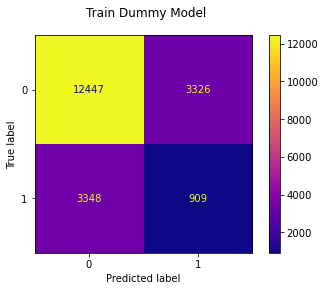

In [31]:
# confusion matrix
fig, ax = plt.subplots()
fig.suptitle('Train Dummy Model')
plot_confusion_matrix(dummy_pipe, X_train, y_train, ax=ax, cmap='plasma');

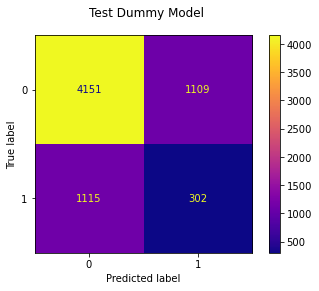

In [32]:
fig, ax = plt.subplots()
fig.suptitle('Test Dummy Model')
plot_confusion_matrix(dummy_pipe, X_test, y_test, ax=ax, cmap='plasma');

The train set has 12,447 true negatives, 3,348 false negatives, 3,326 false positives, and 909 true positives. The test set has 4,151 true negatives, 1,115 false negatives, 1,109 false positives, and 302 true positives. So the model is doing okay at predicting the true negatives, probably because that class size is much larger. It's not doing as well with predicting the true positives, instead drawing up a lot of false results. 

Let's plot ROC curves for train and test. 

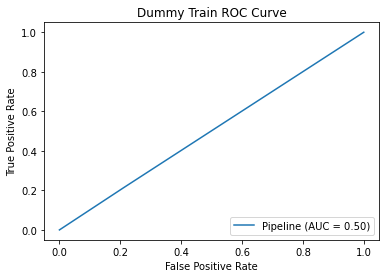

In [33]:
# roc curve
plot_roc_curve(dummy_pipe, X_train, y_train)
plt.title('Dummy Train ROC Curve');

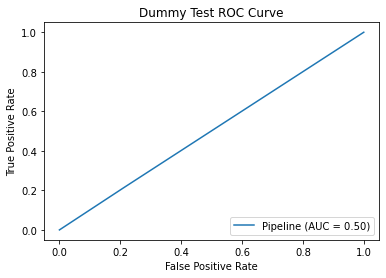

In [34]:
plot_roc_curve(dummy_pipe, X_test, y_test)
plt.title('Dummy Test ROC Curve');

We have an AUC (area under the curve) of 0.50 for both the train and test sets. Again, this isn't a great score. The closer to 1 the score, the better the model as it maximizes true positives and minimizes false positives, which is what we want. 

In [35]:
y_train.value_counts()

h1n1_vaccine
0               15773
1                4257
dtype: int64

We can see here that our target is pretty imbalanced. For the first simple model, let's use SMOTE and the imbpipeline and see if we can do better. 

Here, I'd like to remind myself of the goal, which is to predict whether someone has received their H1N1 vaccine. So we want the model to accurately predict class 1. So if it's actually class 1 and the model predicts class 0, this is a false negative. If it's actually class 0 and the model predicts class 1, this is a false positive. False negatives would be if someone actually got the vaccine, but we're saying they didn't. False positives would be if someone did not get the vaccine, but we're saying they did. 

Having more false positives probably has a bigger negative impact as we're saying someone is vaccinated when in reality they are not. This could cause more health outbreaks as they will be more exposed to contracting and spreading the disease. So we want to try and minimize the false positives. To do this, we want to prioritize higher precision.

### First Simple Model - Logistic Regression (model #2)

As seen above, our target is imbalanced. Let's use SMOTE and see what that does. We need to use the ImPipeline to be able to use SMOTE, so let's create a first simple model using that.

In [36]:
# setting random_state=42 for reproducibility
fsm_pipe = ImPipeline(steps=[
    ('ct', CT),
    ('sm', SMOTE(sampling_strategy='auto', random_state=42)), 
    ('fsm', LogisticRegression(random_state=42))    
])

In [37]:
# I am getting a convergence warning when trying to use just y_train 
# the warning is telling me that a column vector was passed when a 1d array was expected, 
# and to try using ravel, which will flatten the vector

fsm_pipe.fit(X_train, y_train.values.ravel())

C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('bin_pipe',
                                                  Pipeline(steps=[('bin_impute',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                                   'behavioral_outside_home',
                                                   'behavioral_touch_face',
                                                   'doctor_...
                                                   'opinio

Let's take the scores of both train and test. 

In [38]:
print_model_scores(fsm_pipe)

Train Score: 0.7756
Test Score: 0.7797

Train Accuracy: 0.7756
Train Precision: 0.4815
Train Recall: 0.7237
Train F1: 0.5783

Test Accuracy: 0.7797
Test Precision: 0.4871
Test Recall: 0.717
Test F1: 0.5801


This already looks better than the baseline model. The score is about 78%, with precision at 48%, recall at 72%, and F1 at 58% for both the train and test sets. 

Here, we have higher recall than precision, which means that we're minimizing false negatives instead of false positives, which is not what we want. We can confirm that with the confusion matrix. 

In [39]:
# but first, let's save the model
fsm_model_results = ModelWithCV(
    model=fsm_pipe,
    model_name = 'FSM',
    X=X_train,
    y=y_train.values.ravel())

C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

In [40]:
# and cross validate 
fsm_cross_val_score = fsm_model_results.cv_results
fsm_cross_val_score

array([0.76135796, 0.76934598, 0.79281078, 0.76984523, 0.76784823,
       0.77184224, 0.77683475, 0.79181228, 0.7783325 , 0.77034448])

In [41]:
# and print cv results
fsm_model_results.print_cv_summary()

CV Results for `FSM` model:
            0.77504 ± 0.00970 accuracy
        


Let's plot confusion matrices and ROC curves for both train and test.

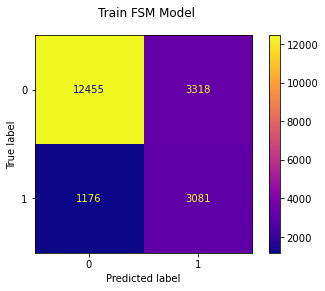

In [42]:
# confusion matrix
fig, ax = plt.subplots()
fig.suptitle('Train FSM Model')
plot_confusion_matrix(fsm_pipe, X_train, y_train, ax=ax, cmap='plasma');

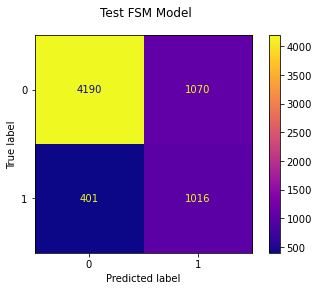

In [43]:
fig, ax = plt.subplots()
fig.suptitle('Test FSM Model')
plot_confusion_matrix(fsm_pipe, X_test, y_test, ax=ax, cmap='plasma');

Yep! The train set has 12,455 true negatives, 1,176 false negatives, 3,318 false positives, and 3,081 true positives. The test set has 4,190 true negatives, 401 false negatives, 1,070 false positives, and 1,016 true positives. Using SMOTE is minimizing the false negatives over the false positives. The results are pretty interesting. It's a better model than our dummy, but I think we can do better still. 

Let's look at the ROC curves. 

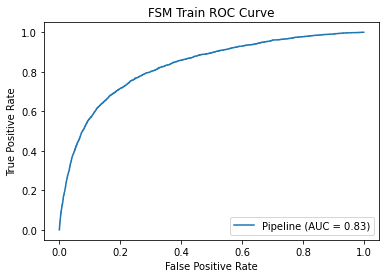

In [44]:
# roc curve
plot_roc_curve(fsm_pipe, X_train, y_train)
plt.title('FSM Train ROC Curve');

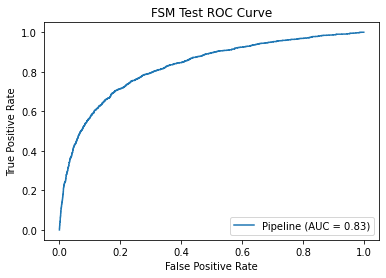

In [45]:
plot_roc_curve(fsm_pipe, X_test, y_test)
plt.title('FSM Test ROC Curve');

The AUC is pretty good at 0.83 for both train and test.

Let's start fine tuning the hyperparameters and see if we can get an even better model.

### First Simple Model Hyperparameter Tuning

Let's first pick the parameters we want to play with. 

In [46]:
# what I can choose from
fsm_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'ct', 'sm', 'fsm', 'ct__n_jobs', 'ct__remainder', 'ct__sparse_threshold', 'ct__transformer_weights', 'ct__transformers', 'ct__verbose', 'ct__bin_pipe', 'ct__ord_pipe', 'ct__cat_pipe', 'ct__bin_pipe__memory', 'ct__bin_pipe__steps', 'ct__bin_pipe__verbose', 'ct__bin_pipe__bin_impute', 'ct__bin_pipe__bin_impute__add_indicator', 'ct__bin_pipe__bin_impute__copy', 'ct__bin_pipe__bin_impute__fill_value', 'ct__bin_pipe__bin_impute__missing_values', 'ct__bin_pipe__bin_impute__strategy', 'ct__bin_pipe__bin_impute__verbose', 'ct__ord_pipe__memory', 'ct__ord_pipe__steps', 'ct__ord_pipe__verbose', 'ct__ord_pipe__ord_impute', 'ct__ord_pipe__ord_impute__add_indicator', 'ct__ord_pipe__ord_impute__copy', 'ct__ord_pipe__ord_impute__fill_value', 'ct__ord_pipe__ord_impute__missing_values', 'ct__ord_pipe__ord_impute__strategy', 'ct__ord_pipe__ord_impute__verbose', 'ct__cat_pipe__memory', 'ct__cat_pipe__steps', 'ct__cat_pipe__verbose', 'ct__cat_pipe__cat_impute', 'ct

In [47]:
# for imputer strategy, I think most_frequent makes the most sense since the numericals are all binary/ordinal
# probably also makes the most sense for categorical
# I didn't specify anything for the logistic regression model, so let's tweak a few of those
# and try to solve the convergence warning I've been getting. 

fsm_params = {
    'fsm__solver' : ['liblinear', 'lbfgs'], 
    'fsm__max_iter': [10, 100,1000,10_000],
    'fsm__C' : [0.0001, 0.001, 0.01, 0.1, 1],
    'fsm__tol' : [0.0001, 0.001, 0.01, 0.1]    
}

In [48]:
# start the grid search process
fsm_gs = GridSearchCV(
    estimator = fsm_pipe,
    param_grid = fsm_params, 
    cv = 5, 
    verbose = 1,
    n_jobs=-1
)

###### PLEASE NOTE: 
This code takes around 10 minutes to run. The results are pasted in commented out code below. 

In [49]:
fsm_gs.fit(X_train, y_train)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:  9.4min finished
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('bin_pipe',
                                                                         Pipeline(steps=[('bin_impute',
                                                                                          SimpleImputer(strategy='most_frequent'))]),
                                                                         ['behavioral_antiviral_meds',
                                                                          'behavioral_avoidance',
                                                                          'behavioral_face_mask',
                                                                          'behavioral_wash_hands',
                                                                          'behavioral_large_gatherings',
                          

In [50]:
# grid search results
# fsm_gs_results = GridSearchCV(cv=5,
#              estimator=Pipeline(steps=[('ct',
#                                         ColumnTransformer(remainder='passthrough',
#                                                           transformers=[('bin_pipe',
#                                                                          Pipeline(steps=[('bin_impute',
#                                                                                           SimpleImputer(strategy='most_frequent'))]),
#                                                                          ['behavioral_antiviral_meds',
#                                                                           'behavioral_avoidance',
#                                                                           'behavioral_face_mask',
#                                                                           'behavioral_wash_hands',
#                                                                           'behavioral_large_gatherings',
#                                                                           'behavioral_outside_home',
#                                                                           'beh...
#                                                                           'race',
#                                                                           'sex',
#                                                                           'income_poverty',
#                                                                           'marital_status',
#                                                                           'rent_or_own',
#                                                                           'employment_status',
#                                                                           'census_msa'])])),
#                                        ('sm', SMOTE(random_state=42)),
#                                        ('fsm',
#                                         LogisticRegression(random_state=42))]),
#              n_jobs=-1,
#              param_grid={'fsm__C': [0.0001, 0.001, 0.01, 0.1, 1],
#                          'fsm__max_iter': [10, 100, 1000, 10000],
#                          'fsm__solver': ['liblinear', 'lbfgs'],
#                          'fsm__tol': [0.0001, 0.001, 0.01, 0.1]},
#              verbose=1)

Let's pull out the best set of parameters from the grid search. 

In [51]:
# here are the params we put in
fsm_params

{'fsm__solver': ['liblinear', 'lbfgs'],
 'fsm__max_iter': [10, 100, 1000, 10000],
 'fsm__C': [0.0001, 0.001, 0.01, 0.1, 1],
 'fsm__tol': [0.0001, 0.001, 0.01, 0.1]}

In [52]:
# here are the best params to use
fsm_gs.best_params_

{'fsm__C': 0.1,
 'fsm__max_iter': 10,
 'fsm__solver': 'liblinear',
 'fsm__tol': 0.1}

In [53]:
# paste the results
# fsm_gs_best_params = 
# {'fsm__C': 0.1,
#  'fsm__max_iter': 10,
#  'fsm__solver': 'liblinear',
#  'fsm__tol': 0.1}

Let's look at these parameters. The solver is probably fine. Max_iter at 10 seems low considering I've been getting convergence warnings telling me to increase the max_iter. The C value is towards the right of the range, and the tol value is all the way to the right. Let's see how these results do, then try adjusting the parameters (change the max_iter range and the fsm_tol range at the least). 

### Model #3: testing the results of the GridSearch

In [54]:
# save the best estimator as fsm_best_pipe
fsm_best_pipe = fsm_gs.best_estimator_

In [55]:
# save the model
fsm_best_pipe_results = ModelWithCV(
    model=fsm_best_pipe, 
    model_name='fsm_gs',
    X=X_train, 
    y=y_train.values.ravel()
)

In [56]:
# save the results in a dataframe so we can look at them later
fsm_best_pipe_df = pd.DataFrame.from_dict(fsm_gs.cv_results_, orient='columns')
fsm_best_pipe_df.head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_fsm__C,param_fsm__max_iter,param_fsm__solver,param_fsm__tol,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.904543,0.043937,0.033205,0.003402,0.0001,10,liblinear,0.0001,"{'fsm__C': 0.0001, 'fsm__max_iter': 10, 'fsm__...",0.663505,0.654768,0.64653,0.669246,0.658762,0.658562,0.007717,153
1,1.887331,0.030014,0.026394,0.008181,0.0001,10,liblinear,0.001,"{'fsm__C': 0.0001, 'fsm__max_iter': 10, 'fsm__...",0.663754,0.654768,0.64653,0.669246,0.658762,0.658612,0.007750,149


Let's look at the scores for the train and test sets. 

In [57]:
# print the rest of the scores
print_model_scores(fsm_best_pipe)

Train Score: 0.7768
Test Score: 0.7789

Train Accuracy: 0.7768
Train Precision: 0.4832
Train Recall: 0.7209
Train F1: 0.5786

Test Accuracy: 0.7789
Test Precision: 0.4858
Test Recall: 0.7121
Test F1: 0.5776


This looks more or less the same as the fsm results. The score is about 78%, with precision at 48%, recall at 72%, and F1 at 58% for both the train and test sets. So this model did better than the baseline, but not sigificantly different than the first simple model. 

Let's plot the confusion matrices and ROC curves. 

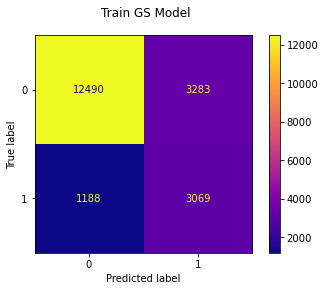

In [58]:
# confusion matrix for train
fig, ax = plt.subplots()
fig.suptitle('Train GS Model')
plot_confusion_matrix(fsm_best_pipe, X_train, y_train, ax=ax, cmap='plasma');

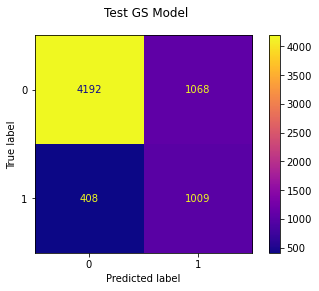

In [59]:
# test confusion matrix
fig, ax = plt.subplots()
fig.suptitle('Test GS Model')
plot_confusion_matrix(fsm_best_pipe, X_test, y_test, ax=ax, cmap='plasma');

The train set has 12,490 true negatives, 1,188 false negatives, 3,283 false positives, and 3,069 true positives. The test set has 4,192 true negatives, 408 false negatives, 1,068 false positives, and 1,009 true positives. 

This model has more true negatives, more false negatives, less false positives, and less true positives than the first simple model. It's doing a better job at minimizing false positives and maximizing false negatives, so it's closer to what we want than the first model. But still just okay. 

Let's look at the ROC curves. 

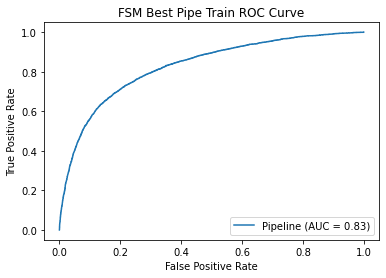

In [60]:
# train roc curve
plot_roc_curve(fsm_best_pipe, X_train, y_train)
plt.title('FSM Best Pipe Train ROC Curve');

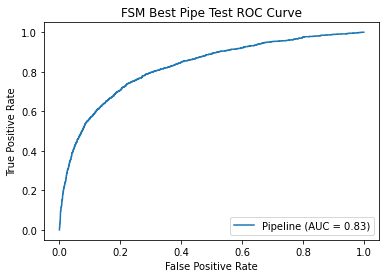

In [61]:
# test roc curve
plot_roc_curve(fsm_best_pipe, X_test, y_test)
plt.title('FSM Best Pipe Test ROC Curve');

The AUC is 0.83 in both the train and test sets, which is what it was for the first simple model. Let's look at the scores again between all three models and confirm the the baseline is performing the worst, and the first simple model adjusted with the grid search parameters is performing the best. 

In [62]:
dummy_model_results.print_cv_summary()

CV Results for `Dummy` model:
            0.66096 ± 0.00752 accuracy
        


In [63]:
fsm_model_results.print_cv_summary()

CV Results for `FSM` model:
            0.77504 ± 0.00970 accuracy
        


In [64]:
fsm_best_pipe_results.print_cv_summary()

CV Results for `fsm_gs` model:
            0.77554 ± 0.01046 accuracy
        


Yep! The first simple model adjusted with the grid search parameters is our best model so far. 

Let's try removing SMOTE from the pipeline and see if that helps our model. 

### Second Simple Model - Logistic Regression with no SMOTE (Model #4)

As I did with the first simple model, I will set the random state to 42 for reproducibility. 

In [65]:
# since I called the first simple model fsm_pipe, let's call this one ssm_pipe for second simple model
# keep random_state=42 for reproducibility
ssm_pipe = Pipeline(steps=[
    ('ct', CT), 
    ('ssm', LogisticRegression(random_state=42)) 
])

In [66]:
# fit it on the train set
ssm_pipe.fit(X_train, y_train.values.ravel())

C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('bin_pipe',
                                                  Pipeline(steps=[('bin_impute',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                                   'behavioral_outside_home',
                                                   'behavioral_touch_face',
                                                   'doctor_...
                                                   'opinio

Let's look at the scores. 

In [67]:
print_model_scores(ssm_pipe)

Train Score: 0.8351
Test Score: 0.8409

Train Accuracy: 0.8351
Train Precision: 0.6833
Train Recall: 0.4181
Train F1: 0.5188

Test Accuracy: 0.8409
Test Precision: 0.7096
Test Recall: 0.4241
Test F1: 0.5309


The score is about 84% for both train and test, with precision at 68% for the train set, and slightly higher at 71% for the test set. Recall is about 42% for both train and test, and the F1 score is about 52% for the train set, and 53% for the test set. 

This model has a higher score/accuracy, a higher precision, and a lower recall. Since we want to minimize false positives and prioritize precision, this is more in line with what we are looking for. 

In [68]:
# save the model
ssm_pipe_results = ModelWithCV(
    model=ssm_pipe, 
    model_name='ssm',
    X=X_train, 
    y=y_train.values.ravel()
)

C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

In [69]:
# cross validate
ssm_cross_val_score = ssm_pipe_results.cv_results
ssm_cross_val_score

array([0.83275087, 0.82775836, 0.83225162, 0.83125312, 0.83724413,
       0.83724413, 0.82825761, 0.84223665, 0.83774338, 0.83175237])

In [70]:
# look at the summary
ssm_pipe_results.print_cv_summary()

CV Results for `ssm` model:
            0.83385 ± 0.00438 accuracy
        


Let's look at the confusion matrices and ROC curves. 

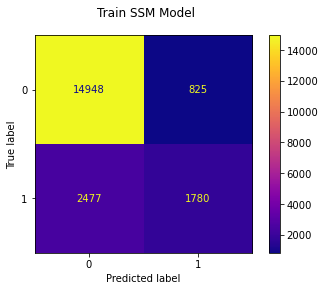

In [71]:
# train confusion matrix
fig, ax = plt.subplots()
fig.suptitle('Train SSM Model')
plot_confusion_matrix(ssm_pipe, X_train, y_train, ax=ax, cmap='plasma');

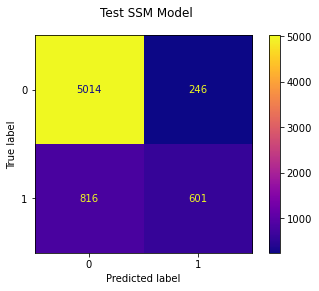

In [72]:
# test confusion matrix
fig, ax = plt.subplots()
fig.suptitle('Test SSM Model')
plot_confusion_matrix(ssm_pipe, X_test, y_test, ax=ax, cmap='plasma');

The train set has 14,948 true negatives, 2,477 false negatives, 825 false positives, and 1,780 true positives. The test set has 5,014 true negatives, 816 false negatives, 246 false positives, and 601 true positives.

We can see here that this model has much fewer false positives than any of the previous models. 

Let's look at the ROC curve. 

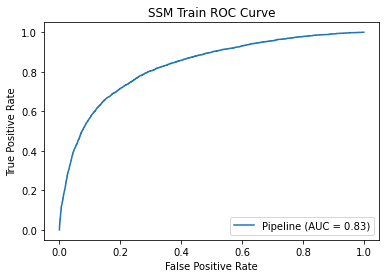

In [73]:
# train ROC curve
plot_roc_curve(ssm_pipe, X_train, y_train)
plt.title('SSM Train ROC Curve');

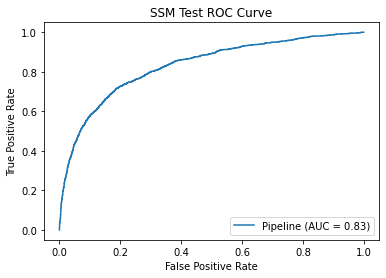

In [74]:
# test ROC curve
plot_roc_curve(ssm_pipe, X_test, y_test)
plt.title('SSM Test ROC Curve');

Again, AUC is 0.83 for both train and test sets. 

Let's do some hyperparameter tuning and see if we can get a better model performance. 

### Second Model Hyperparameter Tuning

Let's pick the hyperparameters we want to adjust. 

In [75]:
# what we can choose from
ssm_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'ct', 'ssm', 'ct__n_jobs', 'ct__remainder', 'ct__sparse_threshold', 'ct__transformer_weights', 'ct__transformers', 'ct__verbose', 'ct__bin_pipe', 'ct__ord_pipe', 'ct__cat_pipe', 'ct__bin_pipe__memory', 'ct__bin_pipe__steps', 'ct__bin_pipe__verbose', 'ct__bin_pipe__bin_impute', 'ct__bin_pipe__bin_impute__add_indicator', 'ct__bin_pipe__bin_impute__copy', 'ct__bin_pipe__bin_impute__fill_value', 'ct__bin_pipe__bin_impute__missing_values', 'ct__bin_pipe__bin_impute__strategy', 'ct__bin_pipe__bin_impute__verbose', 'ct__ord_pipe__memory', 'ct__ord_pipe__steps', 'ct__ord_pipe__verbose', 'ct__ord_pipe__ord_impute', 'ct__ord_pipe__ord_impute__add_indicator', 'ct__ord_pipe__ord_impute__copy', 'ct__ord_pipe__ord_impute__fill_value', 'ct__ord_pipe__ord_impute__missing_values', 'ct__ord_pipe__ord_impute__strategy', 'ct__ord_pipe__ord_impute__verbose', 'ct__cat_pipe__memory', 'ct__cat_pipe__steps', 'ct__cat_pipe__verbose', 'ct__cat_pipe__cat_impute', 'ct__cat_

In [76]:
# same as before, I think the simple imputers are okay with using most-frequent, so let's tweak the log reg parameters.
# I'm going to start of with the same ones as last time and then can tweak again.

ssm_params = {
    'ssm__solver' : ['liblinear', 'lbfgs'], 
    'ssm__max_iter': [10, 100,1000,10_000],
    'ssm__C' : [0.0001, 0.001, 0.01, 0.1, 1],
    'ssm__tol' : [0.0001, 0.001, 0.01, 0.1]    
}

In [77]:
# start the grid search process
ssm_gs = GridSearchCV(
    estimator = ssm_pipe,
    param_grid = ssm_params, 
    cv = 5, 
    verbose = 1, 
    n_jobs=-1 
)

###### Please Note: 
This code takes around 5 minutes to run. Results are pasted below in comments. 

In [78]:
ssm_gs.fit(X_train, y_train)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:  4.9min finished
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('bin_pipe',
                                                                         Pipeline(steps=[('bin_impute',
                                                                                          SimpleImputer(strategy='most_frequent'))]),
                                                                         ['behavioral_antiviral_meds',
                                                                          'behavioral_avoidance',
                                                                          'behavioral_face_mask',
                                                                          'behavioral_wash_hands',
                                                                          'behavioral_large_gatherings',
                          

In [79]:
# saving the results just in case
# ssm_grid_results = GridSearchCV(cv=5,
#              estimator=Pipeline(steps=[('ct',
#                                         ColumnTransformer(remainder='passthrough',
#                                                           transformers=[('bin_pipe',
#                                                                          Pipeline(steps=[('bin_impute',
#                                                                                           SimpleImputer(strategy='most_frequent'))]),
#                                                                          ['behavioral_antiviral_meds',
#                                                                           'behavioral_avoidance',
#                                                                           'behavioral_face_mask',
#                                                                           'behavioral_wash_hands',
#                                                                           'behavioral_large_gatherings',
#                                                                           'behavioral_outside_home',
#                                                                           'beh...
#                                                                                                         sparse=False))]),
#                                                                          ['age_group',
#                                                                           'education',
#                                                                           'race',
#                                                                           'sex',
#                                                                           'income_poverty',
#                                                                           'marital_status',
#                                                                           'rent_or_own',
#                                                                           'employment_status',
#                                                                           'census_msa'])])),
#                                        ('ssm',
#                                         LogisticRegression(random_state=42))]),
#              n_jobs=-1,
#              param_grid={'ssm__C': [0.0001, 0.001, 0.01, 0.1, 1],
#                          'ssm__max_iter': [10, 100, 1000, 10000],
#                          'ssm__solver': ['liblinear', 'lbfgs'],
#                          'ssm__tol': [0.0001, 0.001, 0.01, 0.1]},
#              verbose=1)

Let's find the best parameters and estimator. 

In [80]:
# here are the original params
ssm_params

{'ssm__solver': ['liblinear', 'lbfgs'],
 'ssm__max_iter': [10, 100, 1000, 10000],
 'ssm__C': [0.0001, 0.001, 0.01, 0.1, 1],
 'ssm__tol': [0.0001, 0.001, 0.01, 0.1]}

In [81]:
# here are the best ones
ssm_gs.best_params_

{'ssm__C': 0.1,
 'ssm__max_iter': 100,
 'ssm__solver': 'lbfgs',
 'ssm__tol': 0.0001}

In [82]:
# save the results just in case
# ssm_gs.best_params_ = 
# {'ssm__C': 0.1,
#  'ssm__max_iter': 100,
#  'ssm__solver': 'lbfgs',
#  'ssm__tol': 0.0001}

This is interesting, the best solver is lbfgs. When we were using SMOTE, it was liblinear. Max_iter is 100, which makes more sense. The C value is 0.1, which is fine. The tol value is 0.0001, which is all the way to the left of the range, maybe we'll play with that and adjust it. 

### Model #5: testing the results of the GridSearch

In [83]:
ssm_best_pipe_1 = ssm_gs.best_estimator_
ssm_best_pipe_1

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('bin_pipe',
                                                  Pipeline(steps=[('bin_impute',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                                   'behavioral_outside_home',
                                                   'behavioral_touch_face',
                                                   'doctor_...
                                                   'opinio

In [84]:
# save the model
ssm_best_pipe_1_results = ModelWithCV(
    model=ssm_best_pipe_1, 
    model_name='ssm_best',
    X=X_train, 
    y=y_train.values.ravel()
)

C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

Let's put the results in a dataframe so we can easily look at them. 

In [85]:
ssm_best_pipe_1_df = pd.DataFrame.from_dict(ssm_gs.cv_results_, orient='columns')
ssm_best_pipe_1_df.head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ssm__C,param_ssm__max_iter,param_ssm__solver,param_ssm__tol,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.964893,0.098782,0.079218,0.012077,0.0001,10,liblinear,0.0001,"{'ssm__C': 0.0001, 'ssm__max_iter': 10, 'ssm__...",0.787569,0.787319,0.787569,0.787319,0.787319,0.787419,0.000122,145
1,2.298494,0.312576,0.077432,0.011050,0.0001,10,liblinear,0.001,"{'ssm__C': 0.0001, 'ssm__max_iter': 10, 'ssm__...",0.787569,0.787319,0.787569,0.787319,0.787319,0.787419,0.000122,145


Let's look at the scores. 

In [86]:
print_model_scores(ssm_best_pipe_1)

Train Score: 0.8348
Test Score: 0.84

Train Accuracy: 0.8348
Train Precision: 0.6839
Train Recall: 0.4141
Train F1: 0.5159

Test Accuracy: 0.84
Test Precision: 0.7095
Test Recall: 0.4171
Test F1: 0.5253


The score is 84% for both train and test. Train precision is 68% and test precision is 71%. Train recall is 41% and test recall is 42%. Train F1 score is about 52%, and test F1 score is about 53%. This is more or less the same as the second simple model results. 

Let's look at the confusion matrices and ROC curves to see if there's any major differences there. 

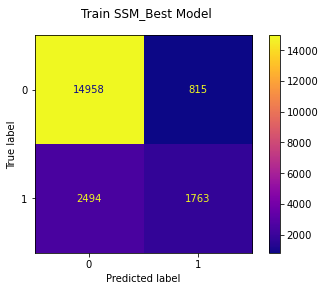

In [87]:
# train confusion matrix
fig, ax = plt.subplots()
fig.suptitle('Train SSM_Best Model')
plot_confusion_matrix(ssm_best_pipe_1, X_train, y_train, ax=ax, cmap='plasma');

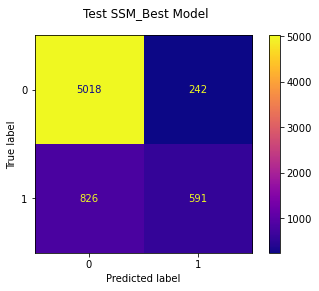

In [88]:
fig, ax = plt.subplots()
fig.suptitle('Test SSM_Best Model')
plot_confusion_matrix(ssm_best_pipe_1, X_test, y_test, ax=ax, cmap='plasma');

The train set has 14,958 true negatives, 2,494 false negatives, 815 false positives, and 1,763 true positives. The test set has 5,018 true negatives, 826 false negatives, 242 false positives, and 591 true positives.

This model when compared to the second simple model has more true negatives, more false negatives, less false positives, and less true positives. Since we want to minimize false positives and maximize true positives, it's hard to say which model is performing better. 

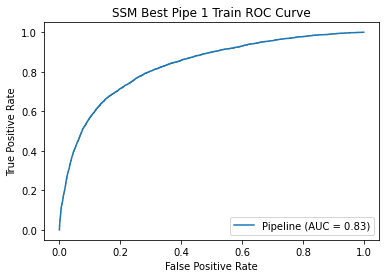

In [89]:
# train ROC curve
plot_roc_curve(ssm_best_pipe_1, X_train, y_train)
plt.title('SSM Best Pipe 1 Train ROC Curve');

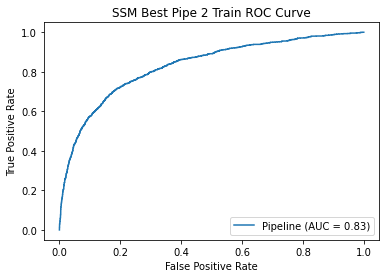

In [90]:
# test ROC curve
plot_roc_curve(ssm_best_pipe_1, X_test, y_test)
plt.title('SSM Best Pipe 2 Train ROC Curve');

The AUC is 0.83 for both train and test, same as it's been. Let's compare the score for each model: the dummy, the first simple model, and the second simple model.

In [91]:
dummy_model_results.print_cv_summary()

CV Results for `Dummy` model:
            0.66096 ± 0.00752 accuracy
        


In [92]:
fsm_model_results.print_cv_summary()

CV Results for `FSM` model:
            0.77504 ± 0.00970 accuracy
        


In [93]:
ssm_pipe_results.print_cv_summary()

CV Results for `ssm` model:
            0.83385 ± 0.00438 accuracy
        


In [94]:
ssm_best_pipe_1_results.print_cv_summary()

CV Results for `ssm_best` model:
            0.83455 ± 0.00380 accuracy
        


The second model adjusted has the highest accuracy. Let's see if we tweak a few more parameters if we can get a significantly better model. 

### Some More Hyperparameter Tuning

There were a few parameters I wanted to tweak, let'st try that now, run another grid search, and see if we can do better. 

In [95]:
# adjusted tol and C
ssm_params_2 = {
    'ssm__solver' : ['liblinear', 'lbfgs'], 
    'ssm__max_iter': [10, 100,1000,10000],
    'ssm__C' : [0.01, 0.1, 10, 100, 300, 500],
    'ssm__tol' : [0.000001, 0.00001, 0.0001, 0.001]    
}

In [96]:
# start the grid search process
ssm_gs_2 = GridSearchCV(
    estimator = ssm_pipe,
    param_grid = ssm_params_2, 
    cv = 5, 
    verbose = 1, 
    n_jobs=-1 
)

In [97]:
# ran at 12:30 done by 12:43
# ran at 4:42 done by 4:54

###### Please Note: 
This code takes about 5 minutes to run. Results are copied and pasted in comments below. 

In [98]:
ssm_gs_2.fit(X_train, y_train)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed:  6.0min finished
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('bin_pipe',
                                                                         Pipeline(steps=[('bin_impute',
                                                                                          SimpleImputer(strategy='most_frequent'))]),
                                                                         ['behavioral_antiviral_meds',
                                                                          'behavioral_avoidance',
                                                                          'behavioral_face_mask',
                                                                          'behavioral_wash_hands',
                                                                          'behavioral_large_gatherings',
                          

In [99]:
# ssm_grid_results_2 = GridSearchCV(cv=5,
#              estimator=Pipeline(steps=[('ct',
#                                         ColumnTransformer(remainder='passthrough',
#                                                           transformers=[('bin_pipe',
#                                                                          Pipeline(steps=[('bin_impute',
#                                                                                           SimpleImputer(strategy='most_frequent'))]),
#                                                                          ['behavioral_antiviral_meds',
#                                                                           'behavioral_avoidance',
#                                                                           'behavioral_face_mask',
#                                                                           'behavioral_wash_hands',
#                                                                           'behavioral_large_gatherings',
#                                                                           'behavioral_outside_home',
#                                                                           'beh...
#                                                                                                         sparse=False))]),
#                                                                          ['age_group',
#                                                                           'education',
#                                                                           'race',
#                                                                           'sex',
#                                                                           'income_poverty',
#                                                                           'marital_status',
#                                                                           'rent_or_own',
#                                                                           'employment_status',
#                                                                           'census_msa'])])),
#                                        ('ssm',
#                                         LogisticRegression(random_state=42))]),
#              n_jobs=-1,
#              param_grid={'ssm__C': [0.01, 0.1, 10, 100, 300, 500],
#                          'ssm__max_iter': [10, 100, 1000, 10000],
#                          'ssm__solver': ['liblinear', 'lbfgs'],
#                          'ssm__tol': [1e-06, 1e-05, 0.0001, 0.001]},
#              verbose=1)

Let's look at the best parameters. 

In [100]:
ssm_params_2

{'ssm__solver': ['liblinear', 'lbfgs'],
 'ssm__max_iter': [10, 100, 1000, 10000],
 'ssm__C': [0.01, 0.1, 10, 100, 300, 500],
 'ssm__tol': [1e-06, 1e-05, 0.0001, 0.001]}

In [101]:
ssm_gs_2.best_params_

{'ssm__C': 10,
 'ssm__max_iter': 10,
 'ssm__solver': 'liblinear',
 'ssm__tol': 1e-06}

In [102]:
# ssm_gs_2.best_params_ = 
# {'ssm__C': 10,
#  'ssm__max_iter': 10,
#  'ssm__solver': 'liblinear',
#  'ssm__tol': 1e-06}

### Model #6: testing the results of the GridSearch

In [103]:
ssm_best_pipe_2 = ssm_gs_2.best_estimator_
ssm_best_pipe_2

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('bin_pipe',
                                                  Pipeline(steps=[('bin_impute',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                                   'behavioral_outside_home',
                                                   'behavioral_touch_face',
                                                   'doctor_...
                                                 ('cat_pip

In [104]:
# save the model
ssm_best_pipe_2_results = ModelWithCV(
    model=ssm_best_pipe_2, 
    model_name='ssm_best2',
    X=X_train, 
    y=y_train.values.ravel()
)

C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\svm\_base.py:976: Converge

In [105]:
# save the results in a dataframe for easy usability
ssm_best_pipe_2_df = pd.DataFrame.from_dict(ssm_gs_2.cv_results_, orient='columns')
ssm_best_pipe_2_df.head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ssm__C,param_ssm__max_iter,param_ssm__solver,param_ssm__tol,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.917281,0.102062,0.082871,0.025881,0.01,10,liblinear,1e-06,"{'ssm__C': 0.01, 'ssm__max_iter': 10, 'ssm__so...",0.826011,0.830754,0.831752,0.831503,0.828757,0.829755,0.002147,157
1,2.183205,0.590112,0.088813,0.010354,0.01,10,liblinear,1e-05,"{'ssm__C': 0.01, 'ssm__max_iter': 10, 'ssm__so...",0.826011,0.830754,0.831752,0.831503,0.828757,0.829755,0.002147,157


Let's check the scores. 

In [106]:
print_model_scores(ssm_best_pipe_2)

Train Score: 0.8349
Test Score: 0.8408

Train Accuracy: 0.8349
Train Precision: 0.6823
Train Recall: 0.4181
Train F1: 0.5185

Test Accuracy: 0.8408
Test Precision: 0.7097
Test Recall: 0.4227
Test F1: 0.5299


The score is 84% for both train and test. Train precision is 68% and test precision is 71%. Train recall is 41% and test recall is 42%. Train F1 score is about 52%, and test F1 score is about 53%. This is more or less the same as the second simple model results and the second simple model_best_params 1 results.

Let's look at the confusion matrix and ROC curve. 

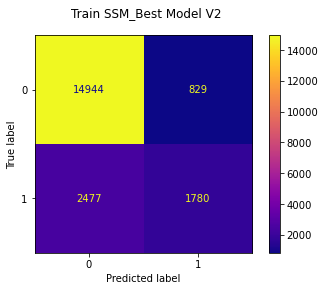

In [107]:
# train confusion matrix
fig, ax = plt.subplots()
fig.suptitle('Train SSM_Best Model V2')
plot_confusion_matrix(ssm_best_pipe_2, X_train, y_train, ax=ax, cmap='plasma');

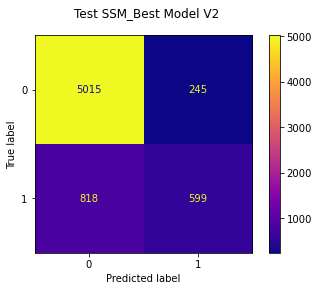

In [108]:
# test confusion matrix
fig, ax = plt.subplots()
fig.suptitle('Test SSM_Best Model V2')
plot_confusion_matrix(ssm_best_pipe_2, X_test, y_test, ax=ax, cmap='plasma');

The train set has 14,944 true negatives, 2,477 false negatives, 829 false positives, and 1,780 true positives. The test set has 5,015 true negatives, 818 false negatives, 245 false positives, and 599 true positives. This is pretty close to our previous model. 

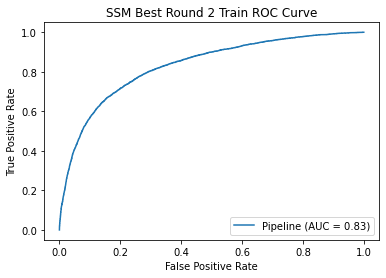

In [109]:
# train ROC
plot_roc_curve(ssm_best_pipe_2, X_train, y_train)
plt.title('SSM Best Round 2 Train ROC Curve');

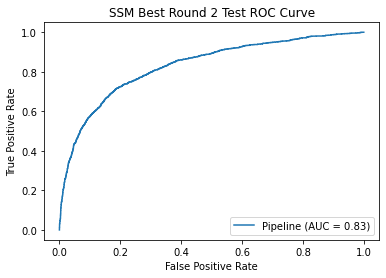

In [110]:
# test ROC
plot_roc_curve(ssm_best_pipe_2, X_test, y_test)
plt.title('SSM Best Round 2 Test ROC Curve');

AUC remains at 0.83. 

### Picking a Final Model

We have created 6 models to choose from: 
1. Model #1: the initial dummy model
2. Model #2: the first simple model using logistic regression and smote
3. Model #3: the best hyperparamter model based on the first simple model
4. Model #4: the second simple model using logistic regression and no smote
5. Model #5: the best hyperparamter model based on the second simple model using 1 set of parameters
6. Model #6: the best hyperparamter model based on the first simple model using a slightly adjusted set of parameters

Let's look at the scores one last time so we can definitively pick a final model. 

In [111]:
print("Model #1 (Dummy):")
print_model_scores(dummy_pipe)

Model #1 (Dummy):
Train Score: 0.6668
Test Score: 0.6669

Train Accuracy: 0.6668
Train Precision: 0.2146
Train Recall: 0.2135
Train F1: 0.2141

Test Accuracy: 0.6669
Test Precision: 0.214
Test Recall: 0.2131
Test F1: 0.2136


In [112]:
print("Model #2 (First Simple Model or fsm_pipe)")
print_model_scores(fsm_pipe)

Model #2 (First Simple Model or fsm_pipe)
Train Score: 0.7756
Test Score: 0.7797

Train Accuracy: 0.7756
Train Precision: 0.4815
Train Recall: 0.7237
Train F1: 0.5783

Test Accuracy: 0.7797
Test Precision: 0.4871
Test Recall: 0.717
Test F1: 0.5801


In [113]:
print("Model #3 (First Simple Model Best or fsm_best_pipe)")
print_model_scores(fsm_best_pipe)

Model #3 (First Simple Model Best or fsm_best_pipe)
Train Score: 0.7768
Test Score: 0.7789

Train Accuracy: 0.7768
Train Precision: 0.4832
Train Recall: 0.7209
Train F1: 0.5786

Test Accuracy: 0.7789
Test Precision: 0.4858
Test Recall: 0.7121
Test F1: 0.5776


In [114]:
print("Model #4 (Second Simple Model or ssm_pipe)")
print_model_scores(ssm_pipe)

Model #4 (Second Simple Model or ssm_pipe)
Train Score: 0.8351
Test Score: 0.8409

Train Accuracy: 0.8351
Train Precision: 0.6833
Train Recall: 0.4181
Train F1: 0.5188

Test Accuracy: 0.8409
Test Precision: 0.7096
Test Recall: 0.4241
Test F1: 0.5309


In [115]:
print("Model #5 (Second Simple Model Best 1 or ssm_best_pipe_1)")
print_model_scores(ssm_best_pipe_1)

Model #5 (Second Simple Model Best 1 or ssm_best_pipe_1)
Train Score: 0.8348
Test Score: 0.84

Train Accuracy: 0.8348
Train Precision: 0.6839
Train Recall: 0.4141
Train F1: 0.5159

Test Accuracy: 0.84
Test Precision: 0.7095
Test Recall: 0.4171
Test F1: 0.5253


In [116]:
print("Model #6 (Second Simple Model Best 2 or ssm_best_pipe_2)")
print_model_scores(ssm_best_pipe_2)

Model #6 (Second Simple Model Best 2 or ssm_best_pipe_2)
Train Score: 0.8349
Test Score: 0.8408

Train Accuracy: 0.8349
Train Precision: 0.6823
Train Recall: 0.4181
Train F1: 0.5185

Test Accuracy: 0.8408
Test Precision: 0.7097
Test Recall: 0.4227
Test F1: 0.5299


It looks like model 6 is slightly better than model 5. So we need to choose between model 4 and model 6 as they had the highest overall performance. 

When looking at the test set, the scores between model 4 and model 5 are very similar. Model 4 has marginally better results, but not a significant amount. 

Let's look again at the confusion matrices for the test set. 

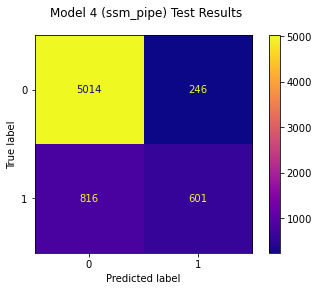

In [117]:
fig, ax = plt.subplots()
fig.suptitle('Model 4 (ssm_pipe) Test Results')
plot_confusion_matrix(ssm_pipe, X_test, y_test, ax=ax, cmap='plasma');

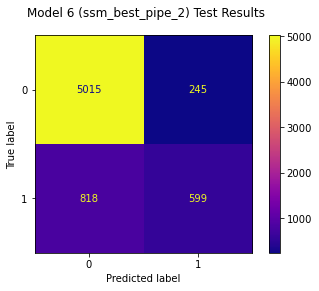

In [118]:
fig, ax = plt.subplots()
fig.suptitle('Model 6 (ssm_best_pipe_2) Test Results')
plot_confusion_matrix(ssm_best_pipe_2, X_test, y_test, ax=ax, cmap='plasma');

These models are very similar. The confusion matrices differ by 1 or 2 data points in favor of model 6, but the metrics such as accuracy, precision, and recall favor model 4. Due to the similarity, I do not think choosing one model over the other will have a significant change in results, so I will choose model 4 as my final model. 

### Setting Model 4 as the final model

Let's review the results from model 4. 

In [119]:
# set final model = model 4 (the ssm_pipe)
final_model = ssm_pipe

In [120]:
print_model_scores(final_model)

Train Score: 0.8351
Test Score: 0.8409

Train Accuracy: 0.8351
Train Precision: 0.6833
Train Recall: 0.4181
Train F1: 0.5188

Test Accuracy: 0.8409
Test Precision: 0.7096
Test Recall: 0.4241
Test F1: 0.5309


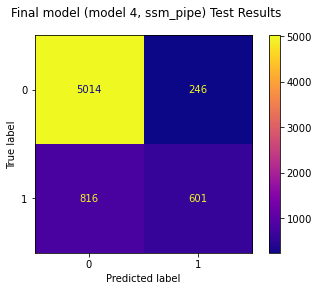

In [121]:
fig, ax = plt.subplots()
fig.suptitle('Final model (model 4, ssm_pipe) Test Results')
plot_confusion_matrix(final_model, X_test, y_test, ax=ax, cmap='plasma');

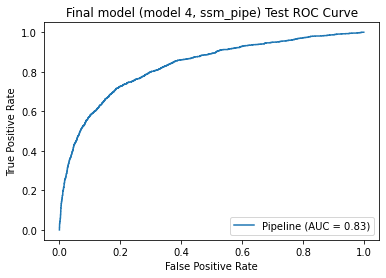

In [122]:
# train ROC
plot_roc_curve(final_model, X_test, y_test)
plt.title('Final model (model 4, ssm_pipe) Test ROC Curve');

### Making predicitions/recommendations using Model 4

In order to make predictions and recommendations, let's use the final model to predict our test values. Then I think what makes the most sense is to use the test set, combine it with those predictions, and then analyze that dataframe and make predictions/recommendations.  

So let's do it. 

In [123]:
# make the final predictions
final_model_pred = final_model.predict(X_test)

In [124]:
# let's make a copy of X_test so we don't mess anything up with it
X_test_predictions = X_test.copy()

In [125]:
# add the final predictions to X_test_predictions
X_test_predictions['preds'] = final_model_pred

In [126]:
# check it out
X_test_predictions.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,race,sex,income_poverty,marital_status,rent_or_own,employment_status,census_msa,household_adults,household_children,preds
respondent_id,,,,,,,,,,,,,,,,,,,,,
15772,2.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,White,Female,NaN,NaN,NaN,NaN,"MSA, Principle City",NaN,NaN,0
9407,3.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,...,White,Male,NaN,NaN,NaN,NaN,"MSA, Principle City",1.0,1.0,0
16515,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,White,Female,NaN,Not Married,Own,Employed,"MSA, Not Principle City",0.0,1.0,0
23353,2.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,White,Female,"> $75,000",Married,Own,Employed,Non-MSA,1.0,2.0,0
10008,1.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,White,Male,"> $75,000",Married,Own,Employed,"MSA, Principle City",1.0,0.0,0


Let's start comparing. From my general EDA before getting into the modeling, I saw a few trends that I'd like to explore here. 

First, let's look at the correlations to H1N1 vaccine. 

In [127]:
h1n1_corrs = abs(X_test_predictions.corr()['preds']).sort_values(ascending=False)
h1n1_corrs_df = pd.DataFrame(h1n1_corrs)
h1n1_corrs_df

,preds
preds,1.000000
doctor_recc_h1n1,0.637774
opinion_h1n1_risk,0.431595
doctor_recc_seasonal,0.363879
opinion_seas_risk,0.326913
opinion_h1n1_vacc_effective,0.310936
health_worker,0.236384
opinion_seas_vacc_effective,0.203447
h1n1_knowledge,0.158911
chronic_med_condition,0.147323


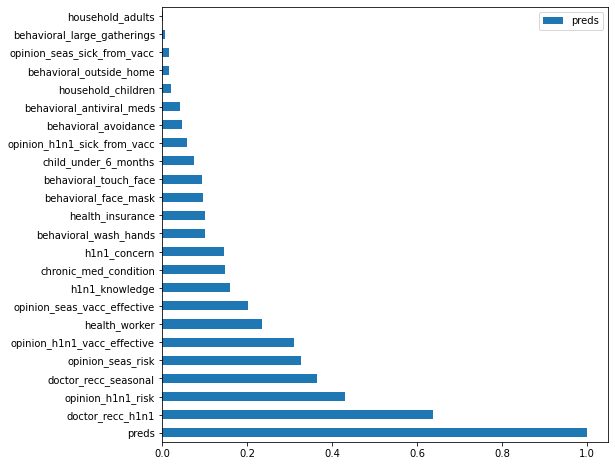

In [128]:
h1n1_corrs_df.plot(kind='barh', figsize=(8,8));

Doctor recommendation has the highest positive correlation to our predicted H1N1 vaccine status, around 64%. Opinion on the risk of the vaccine also has high positive correlations of 43%. 

Let's explore these further, statrting with the doctor recommendation. 

In [129]:
# split up the dataframe into not vaccinated (0) or vaccinated (1)
not_vaccinated = X_test_predictions.loc[X_test_predictions['preds'] == 0]
vaccinated = X_test_predictions.loc[X_test_predictions['preds'] == 1]

Let's group by the doctor recommendation: 0 (or No) for has not recommended the vaccine, and 1 (or Yes) for has recommended the vaccine. 

In [130]:
not_vacc_doc_rec = not_vaccinated.groupby('doctor_recc_h1n1')[['preds']].count()
vacc_doc_rec = vaccinated.groupby('doctor_recc_h1n1')[['preds']].count()

Let's visualize it. 

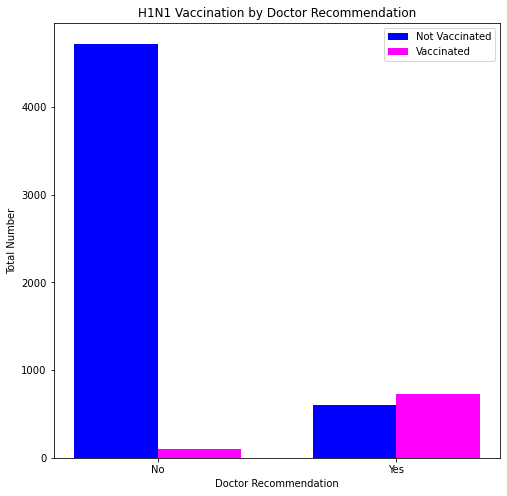

In [131]:
fig, ax = plt.subplots(figsize=(8,8))
bar_width = 0.35

index = range(len(not_vacc_doc_rec))
x_not_vaccinated = [i - bar_width/2 for i in index]
x_vaccinated = [i + bar_width/2 for i in index]


ax.bar(x=x_not_vaccinated, height=not_vacc_doc_rec['preds'].values, 
       label='Not Vaccinated', width=bar_width, color='blue')

ax.bar(x=x_vaccinated, height=vacc_doc_rec['preds'].values, 
       label='Vaccinated', width=bar_width, color='magenta')

ax.set_xlabel('Doctor Recommendation')
ax.set_ylabel('Total Number')
ax.set_title('H1N1 Vaccination by Doctor Recommendation')
ax.set_xticks(index)
ax.set_xticklabels(['No', 'Yes'])
ax.legend()
plt.show();

It looks like if the doctor did not recommend the vaccine, there were a significant number of unvaccinated people. However, when the doctor did recommend the vaccine, the number of vaccinated surpassed the number of unvaccinated. This makes sense, people tend to follow doctor's orders.

It's a little hard to see the vaccinated counts, since the unvaccinated count is so high. Let's zoom in on the vaccination status. 

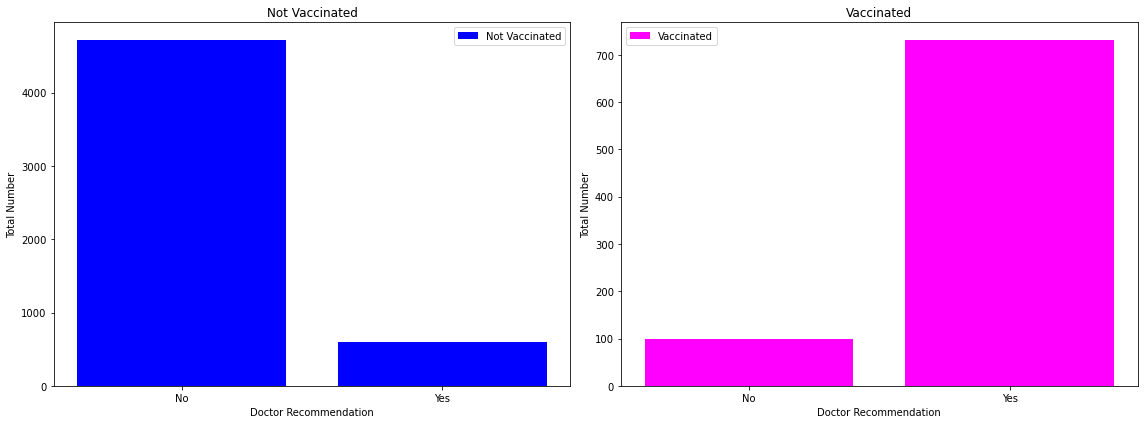

In [132]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# plot the not vaccinated on the left
ax[0].bar(x=not_vacc_doc_rec['preds'].index, 
            height=not_vacc_doc_rec['preds'].values, 
            label='Not Vaccinated', color='blue')

ax[0].set_title('Not Vaccinated')
ax[0].set_xlabel('Doctor Recommendation')
ax[0].set_ylabel('Total Number')
ax[0].set_xticks([0,1])
ax[0].set_xticklabels(['No', 'Yes'])
ax[0].legend()

# plot the vaccinated on the right
ax[1].bar(x=vacc_doc_rec['preds'].index, 
            height=vacc_doc_rec['preds'].values, 
            label='Vaccinated', color='magenta')

ax[1].set_title('Vaccinated')
ax[1].set_xlabel('Doctor Recommendation')
ax[1].set_ylabel('Total Number')
ax[1].set_xticks([0,1])
ax[1].set_xticklabels(['No', 'Yes'])
ax[1].legend()

plt.tight_layout()
plt.show();

You can see much clearer here: when the doctor did not recommend the vaccine, nearly 5,000 people did not get vaccined, and only just under 1000 got vaccinated. On the other hand, when the doctor did recommend the vaccine, over 700 people vaccinated, and 100 did not get vaccinated. 

My recommendation here would be keep this trend going and get more doctors and healthcare professionals to encourage vaccinations. 

Next, let's look at how the opinion of the risk of getting the disease without the vaccine holds up with our predictions. 

In [133]:
# group the vaccinated/not vaccinated dataframes created earlier
# group by opinion_h1n1_risk
not_vacc_risk_opinion = not_vaccinated.groupby('opinion_h1n1_risk')[['preds']].count()
vacc_risk_opinion = vaccinated.groupby('opinion_h1n1_risk')[['preds']].count()

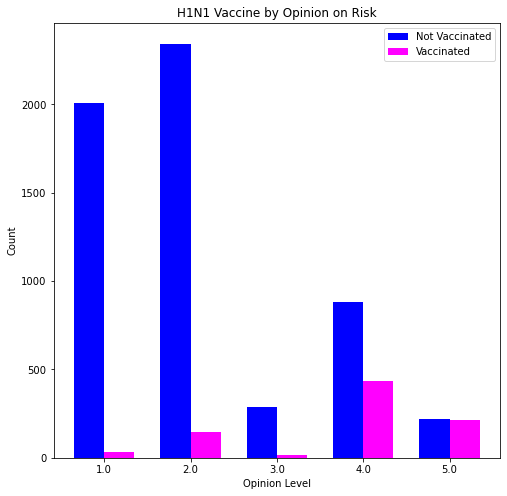

In [134]:
# Let's plot it
opinion = vacc_risk_opinion.index

fig, ax = plt.subplots(figsize=(8,8))
bar_width = 0.35

index = range(len(not_vacc_risk_opinion))
x_not_vaccinated = [i - bar_width/2 for i in index]
x_vaccinated = [i + bar_width/2 for i in index]


ax.bar(x=x_not_vaccinated, height=not_vacc_risk_opinion['preds'].values, 
       label='Not Vaccinated', width=bar_width, color='blue')

ax.bar(x=x_vaccinated, height=vacc_risk_opinion['preds'].values, 
       label='Vaccinated', width=bar_width, color='magenta')

ax.set_xlabel('Opinion Level')
ax.set_ylabel('Count')
ax.set_title('H1N1 Vaccine by Opinion on Risk')
ax.set_xticks(index)
ax.set_xticklabels(opinion)
ax.legend()
plt.show();

According to the data dictionary, 1 is the lowest level of concern, and 5 is the highest level of concern. These results aren't surprising. People who think there is a low risk of getting sick without the vaccine have the highest unvaccinated counts, where those who are more concerned are more likely to be vaccinated. 

This is useful information, but I don't think it's enough to make a good recommendation on. Let's look at level of knowledge about the H1N1 flu is distributed. 

In [135]:
# group the vaccinated/not vaccinated dataframes by h1n1_concern
not_vacc_knowledge = not_vaccinated.groupby('h1n1_knowledge')[['preds']].count()
vacc_knowledge = vaccinated.groupby('h1n1_knowledge')[['preds']].count()

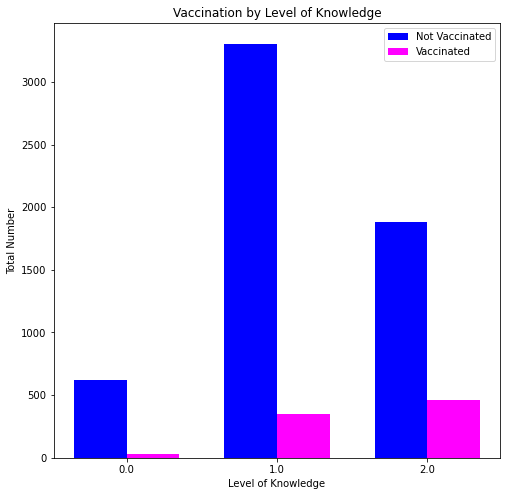

In [136]:
# plot it
level_knowledge = vacc_knowledge.index

fig, ax = plt.subplots(figsize=(8,8))
bar_width = 0.35

index = range(len(not_vacc_knowledge))
x_not_vaccinated = [i - bar_width/2 for i in index]
x_vaccinated = [i + bar_width/2 for i in index]


ax.bar(x=x_not_vaccinated, height=not_vacc_knowledge['preds'].values, 
       label='Not Vaccinated', width=bar_width, color='blue')

ax.bar(x=x_vaccinated, height=vacc_knowledge['preds'].values, 
       label='Vaccinated', width=bar_width, color='magenta')

ax.set_xlabel('Level of Knowledge')
ax.set_ylabel('Total Number')
ax.set_title('Vaccination by Level of Knowledge')
ax.set_xticks(index)
ax.set_xticklabels(level_knowledge)
ax.legend()
plt.show();

It looks like people with a lot of knowledge about the virus (2) have the highed vaccinated counts. Let's zoom in on it. 

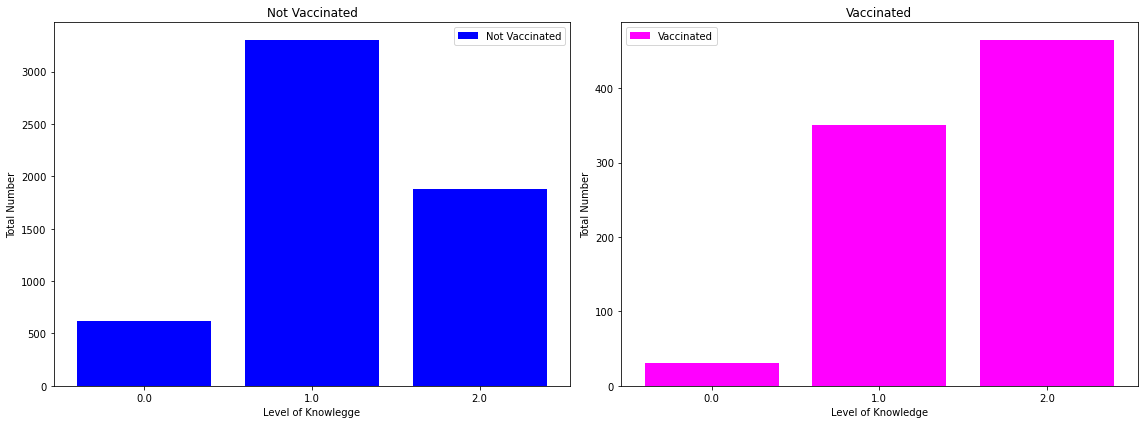

In [137]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# plot the not vaccinated on the left
ax[0].bar(x=not_vacc_knowledge['preds'].index, 
            height=not_vacc_knowledge['preds'].values, 
            label='Not Vaccinated', color='blue')

ax[0].set_title('Not Vaccinated')
ax[0].set_xlabel('Level of Knowlegge')
ax[0].set_ylabel('Total Number')
ax[0].legend()
ax[0].set_xticks([0, 1, 2])
ax[0].set_xticklabels(level_knowledge)

# plot the vaccinated on the right
ax[1].bar(x=vacc_knowledge['preds'].index, 
            height=vacc_knowledge['preds'].values, 
            label='Vaccinated', color='magenta')

ax[1].set_title('Vaccinated')
ax[1].set_xlabel('Level of Knowledge')
ax[1].set_ylabel('Total Number')
ax[1].legend()
ax[1].set_xticks([0, 1, 2])
ax[1].set_xticklabels(level_knowledge)

plt.tight_layout()
plt.show();

It looks like the more knowledge about the H1N1 flu, the higher the vaccinated count. I'm curious how education level plays a role in this. 

First, let's look at just education level. Then, let's look at education level and H1N1 knowledge grouped together. 

In [138]:
# group the vaccinated and not vaccinated dataframes by education level
not_vacc_education = not_vaccinated.groupby('education')[['preds']].count().sort_values(by='preds', ascending=False)
vacc_education = vaccinated.groupby('education')[['preds']].count().sort_values(by='preds', ascending=False)

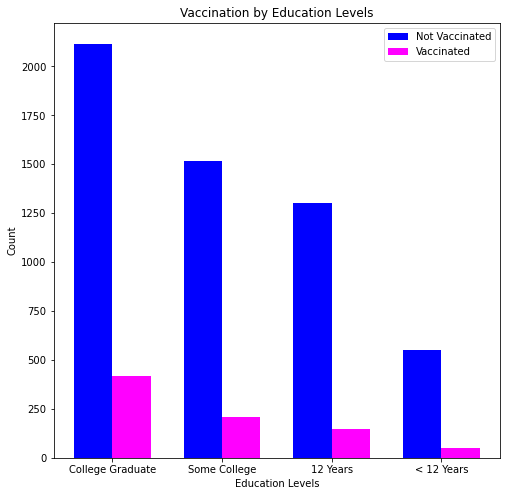

In [139]:
# plot it
ed_lev = vacc_education.index

fig, ax = plt.subplots(figsize=(8,8))
bar_width = 0.35

index = range(len(not_vacc_education))
x_not_vaccinated = [i - bar_width/2 for i in index]
x_vaccinated = [i + bar_width/2 for i in index]


ax.bar(x=x_not_vaccinated, height=not_vacc_education['preds'].values, 
       label='Not Vaccinated', width=bar_width, color='blue')

ax.bar(x=x_vaccinated, height=vacc_education['preds'].values, 
       label='Vaccinated', width=bar_width, color='magenta')

ax.set_xlabel('Education Levels')
ax.set_ylabel('Count')
ax.set_title('Vaccination by Education Levels')
ax.set_xticks(index)
ax.set_xticklabels(ed_lev)
ax.legend()
plt.show();

It looks like those with the highest levels of education have the highest vaccination counts. Let's group education and H1N1 level of knowledge. 

In [140]:
# group the vaccinated/not vaccinated dataframes by education level and level of knowledge
not_vacc_ed_know = not_vaccinated.groupby(['h1n1_knowledge', 'education'])[['preds']].count().sort_values(by='education', ascending=False)
vacc_ed_know = vaccinated.groupby(['h1n1_knowledge', 'education'])[['preds']].count().sort_values(by='education', ascending=False)

In [141]:
list(not_vacc_ed_know['preds'].index)

[(0.0, 'Some College'),
 (1.0, 'Some College'),
 (2.0, 'Some College'),
 (0.0, 'College Graduate'),
 (1.0, 'College Graduate'),
 (2.0, 'College Graduate'),
 (0.0, '< 12 Years'),
 (1.0, '< 12 Years'),
 (2.0, '< 12 Years'),
 (0.0, '12 Years'),
 (1.0, '12 Years'),
 (2.0, '12 Years')]

In [142]:
# our index is a list of tuples, let's join them. 
# since level of concern is a number (0, 1, or 2) let's change it so that they represent in a string the level of knowledge

original_index_ed = list(not_vacc_ed_know['preds'].index)
joined_index_ed = []

for item in original_index_ed:
    if item[0] == 0:
        joined_index_ed.append(f'No H1N1 knowledge: {item[1]}')
    elif item[0] == 1:
        joined_index_ed.append(f'A little H1N1 knowledge: {item[1]}')
    else:
        joined_index_ed.append(f'A lot of H1N1 knowledge: {item[1]}')
print(joined_index_ed)

['No H1N1 knowledge: Some College', 'A little H1N1 knowledge: Some College', 'A lot of H1N1 knowledge: Some College', 'No H1N1 knowledge: College Graduate', 'A little H1N1 knowledge: College Graduate', 'A lot of H1N1 knowledge: College Graduate', 'No H1N1 knowledge: < 12 Years', 'A little H1N1 knowledge: < 12 Years', 'A lot of H1N1 knowledge: < 12 Years', 'No H1N1 knowledge: 12 Years', 'A little H1N1 knowledge: 12 Years', 'A lot of H1N1 knowledge: 12 Years']


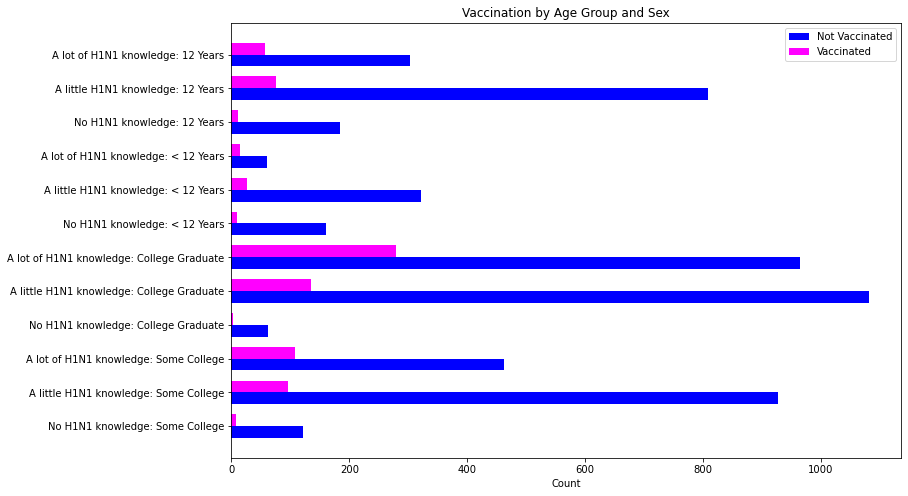

In [143]:
# plot it
fig, ax = plt.subplots(figsize=(12, 8))
bar_height = 0.35

index = range(len(not_vacc_ed_know))
y_not_vaccinated = [i - bar_height/2 for i in index]
y_vaccinated = [i + bar_height/2 for i in index]

# Use the barh function for horizontal bar graph
ax.barh(y=y_not_vaccinated, width=not_vacc_ed_know['preds'], 
        label='Not Vaccinated', height=bar_height, color='blue')

ax.barh(y=y_vaccinated, width=vacc_ed_know['preds'], 
        label='Vaccinated', height=bar_height, color='magenta')

ax.set_xlabel('Count')
ax.set_title('Vaccination by Age Group and Sex')
ax.set_yticks(index)
ax.set_yticklabels(joined_index_ed)
ax.legend()
plt.show();

Those with 12 years (or less) of education have the lowest unvaccinated counts. It looks regardless of education level, those with no knowledge of the H1N1 flu have very low vaccination counts. Those who graduated college and have a lot of knowledge about the virus have the highest vaccination counts of any grouping. In general, those with more knowledge about the virus are the vaccinated ones. Let's zoom in on these a little bit. 

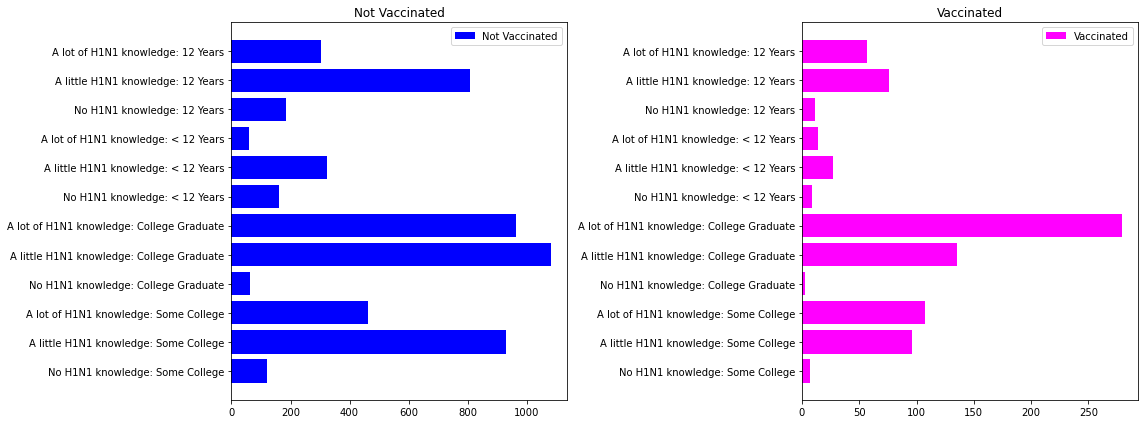

In [144]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# plot the not vaccinated on the left
ax[0].barh(y=joined_index_ed, 
            width=not_vacc_ed_know['preds'].values, 
            label='Not Vaccinated', color='blue')

ax[0].set_title('Not Vaccinated')
ax[0].legend()

# plot the vaccinated on the right
ax[1].barh(y=joined_index_ed, 
            width=vacc_ed_know['preds'].values, 
            label='Vaccinated', color='magenta')

ax[1].set_title('Vaccinated')
ax[1].legend()

plt.tight_layout()
plt.show();

From this, and the zoomed in graphs above showing just level of H1N1 knowledge, I can see that more knowledge about the virus leads to more vaccinations. College graduates have the highest counts of vaccinations, and even those who attended some college have high counts. 

From this, I would recommend spreading as much correct information about the H1N1 flu as possible, as the more information people have about it, the better. I would also suggest reaching out to those with 12 years of education (or less) and finding a way to connect/provide them with the knowledge about the virus. 

Let's look at a few other factors as well, starting with age group.  

In [145]:
# group the vaccinated/not vaccinated dataframes by age group
not_vacc_age_grouped = not_vaccinated.groupby('age_group')[['preds']].count().sort_values(by='preds', ascending=False)
vacc_age_grouped = vaccinated.groupby('age_group')[['preds']].count().sort_values(by='preds', ascending=False)

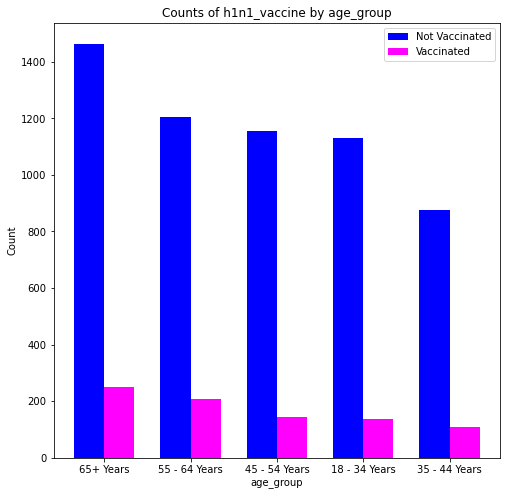

In [146]:
# plot it
age_groups = vacc_age_grouped.index

fig, ax = plt.subplots(figsize=(8,8))
bar_width = 0.35

index = range(len(not_vacc_age_grouped))
x_not_vaccinated = [i - bar_width/2 for i in index]
x_vaccinated = [i + bar_width/2 for i in index]


ax.bar(x=x_not_vaccinated, height=not_vacc_age_grouped['preds'].values, 
       label='Not Vaccinated', width=bar_width, color='blue')

ax.bar(x=x_vaccinated, height=vacc_age_grouped['preds'].values, 
       label='Vaccinated', width=bar_width, color='magenta')

ax.set_xlabel('age_group')
ax.set_ylabel('Count')
ax.set_title('Counts of h1n1_vaccine by age_group')
ax.set_xticks(index)
ax.set_xticklabels(age_groups)
ax.legend()
plt.show();

It looks like the older generations have both the highest counts of vaccinated vs unvaccinated, with 35-44 year olds have the lowest counts of both. 

I'm curious how gender plays a role in that. 

In [147]:
# group the vaccinated/not vaccinated dataframes by age-group and sex
not_vacc_age_sex = not_vaccinated.groupby(['age_group', 'sex'])[['preds']].count().sort_values(by='age_group', ascending=False)
vacc_age_sex = vaccinated.groupby(['age_group', 'sex'])[['preds']].count().sort_values(by='age_group', ascending=False)

The index for this grouping will be a tuple of age and sex. I'd like to combine them into one string so it's a little cleaner when we plot it. Let's try it. 

In [148]:
# our index is a list of tuples
# joining the tuples
original_index = list(not_vacc_age_sex['preds'].index)
joined_index = [': '.join(element) for element in original_index]
print(joined_index)

['65+ Years: Female', '65+ Years: Male', '55 - 64 Years: Female', '55 - 64 Years: Male', '45 - 54 Years: Female', '45 - 54 Years: Male', '35 - 44 Years: Female', '35 - 44 Years: Male', '18 - 34 Years: Female', '18 - 34 Years: Male']


And let's plot it. 

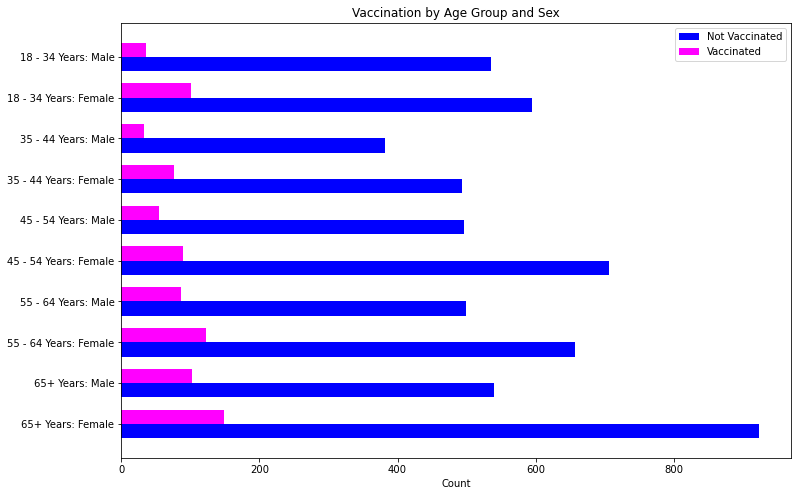

In [149]:
fig, ax = plt.subplots(figsize=(12, 8))  # Adjust the figsize as needed
bar_height = 0.35

index = range(len(not_vacc_age_sex))
y_not_vaccinated = [i - bar_height/2 for i in index]
y_vaccinated = [i + bar_height/2 for i in index]

# Use the barh function for horizontal bar graph
ax.barh(y=y_not_vaccinated, width=not_vacc_age_sex['preds'], 
        label='Not Vaccinated', height=bar_height, color='blue')

ax.barh(y=y_vaccinated, width=vacc_age_sex['preds'], 
        label='Vaccinated', height=bar_height, color='magenta')

ax.set_xlabel('Count')
ax.set_title('Vaccination by Age Group and Sex')
ax.set_yticks(index)
ax.set_yticklabels(joined_index)
ax.legend()
plt.show();

Males aged 18-34 and 35-44 have the lowest counts of vaccination. It looks like in general, females have higher vaccination counts, particularly those aged 65+. I think it will help to zoom in on the individual age/sex combinations. 

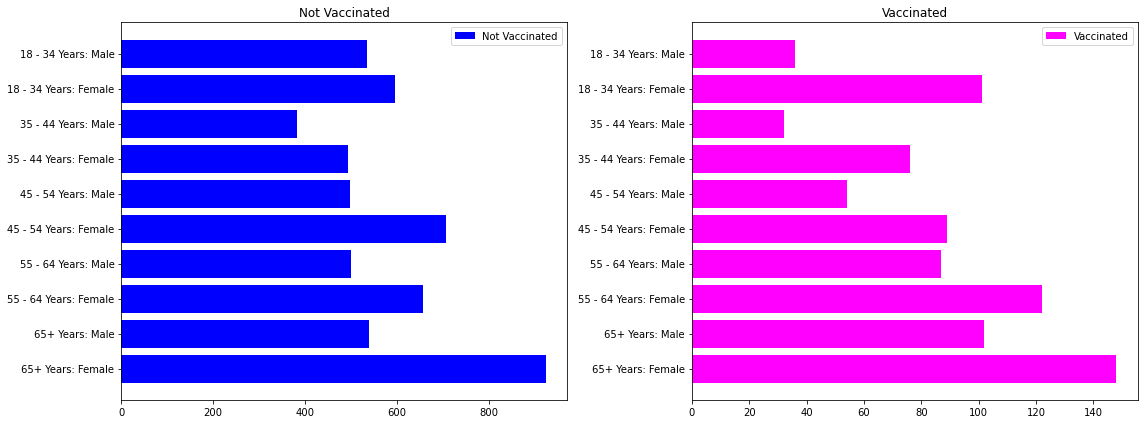

In [150]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# plot the not vaccinated on the left
ax[0].barh(y=joined_index, 
            width=not_vacc_age_sex['preds'].values, 
            label='Not Vaccinated', color='blue')

ax[0].set_title('Not Vaccinated')
ax[0].legend()

# plot the vaccinated on the right
ax[1].barh(y=joined_index, 
            width=vacc_age_sex['preds'].values, 
            label='Vaccinated', color='magenta')

ax[1].set_title('Vaccinated')
ax[1].legend()

plt.tight_layout()
plt.show();

This is a lot clearer to see: for all age groups, females have higher vaccination counts, with 65+ having the highest count. 35-44 year old males have the lowest vaccination counts of any age/sex combination, followed closerly by 18-34 year old males. 

Looking at this, I would recommend that we find ways to target males aged 18-44 and encourage them to get vaccinated. 

So now, we have three decent recommendations: have doctors encourage vaccinations, spread awareness of knowledge of the H1N1 flu, and find ways to reach males aged 18-44. 

There were a few more columns I wanted to explore, let's look and see if there's anything stronger than the current recommendations. 

First, let's see if employment has an impact.

In [151]:
# group the vaccinated and not vaccinated dataframes by employment status
not_vacc_employment_status = not_vaccinated.groupby('employment_status')[['preds']].count().sort_values(by='preds', 
                                                                                             ascending=False)
vacc_employment_status = vaccinated.groupby('employment_status')[['preds']].count().sort_values(by='preds', 
                                                                                             ascending=False)

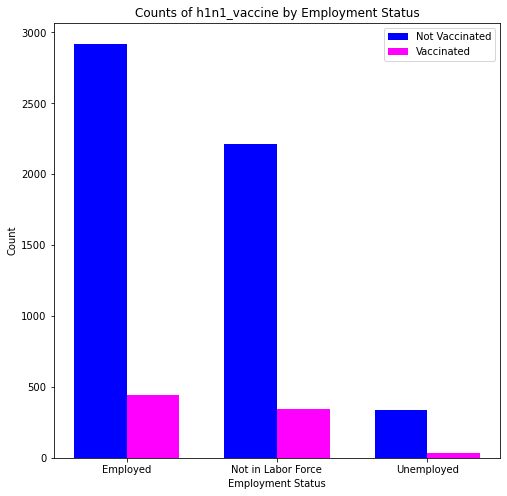

In [152]:
# plot it
employ_stat = vacc_employment_status.index

fig, ax = plt.subplots(figsize=(8,8))
bar_width = 0.35

index = range(len(not_vacc_employment_status))
x_not_vaccinated = [i - bar_width/2 for i in index]
x_vaccinated = [i + bar_width/2 for i in index]


ax.bar(x=x_not_vaccinated, height=not_vacc_employment_status['preds'].values, 
       label='Not Vaccinated', width=bar_width, color='blue')

ax.bar(x=x_vaccinated, height=vacc_employment_status['preds'].values, 
       label='Vaccinated', width=bar_width, color='magenta')

ax.set_xlabel('Employment Status')
ax.set_ylabel('Count')
ax.set_title('Counts of h1n1_vaccine by Employment Status')
ax.set_xticks(index)
ax.set_xticklabels(employ_stat)
ax.legend()
plt.show();

This isn't surprising: the unemployed group has the smallest vaccination counts, and employed has the largest.

Let's look at income level. 

In [153]:
# group the vaccinated and not vaccinated dataframes by income level
not_vacc_income_poverty = not_vaccinated.groupby('income_poverty')[['preds']].count().sort_values(by='preds', ascending=False)
vacc_income_poverty = vaccinated.groupby('income_poverty')[['preds']].count().sort_values(by='preds', ascending=False)

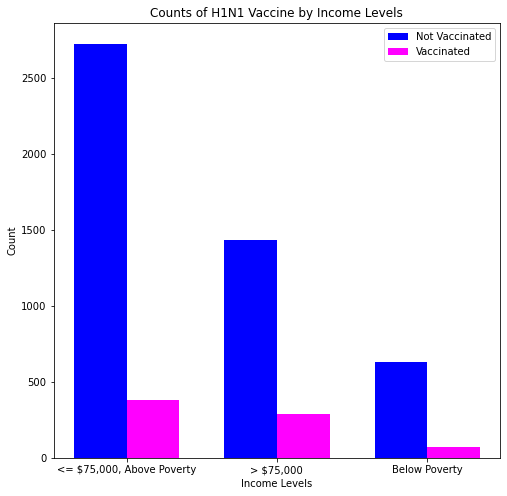

In [154]:
pov_lev = vacc_income_poverty.index

fig, ax = plt.subplots(figsize=(8,8))
bar_width = 0.35

index = range(len(not_vacc_income_poverty))
x_not_vaccinated = [i - bar_width/2 for i in index]
x_vaccinated = [i + bar_width/2 for i in index]


ax.bar(x=x_not_vaccinated, height=not_vacc_income_poverty['preds'].values, 
       label='Not Vaccinated', width=bar_width, color='blue')

ax.bar(x=x_vaccinated, height=vacc_income_poverty['preds'].values, 
       label='Vaccinated', width=bar_width, color='magenta')

ax.set_xlabel('Income Levels')
ax.set_ylabel('Count')
ax.set_title('Counts of H1N1 Vaccine by Income Levels')
ax.set_xticks(index)
ax.set_xticklabels(pov_lev)
ax.legend()
plt.show();

Again, this is not surprising. Those below poverty have the smallest counts of vaccinations, and those above poverty have the highest counts of vaccinations. 

How does level of concern about the H1N1 flu factor in?

In [155]:
# group the vaccinated/not vaccinated dataframes by h1n1_concern
not_vacc_concern = not_vaccinated.groupby('h1n1_concern')[['preds']].count()
vacc_concern = vaccinated.groupby('h1n1_concern')[['preds']].count()

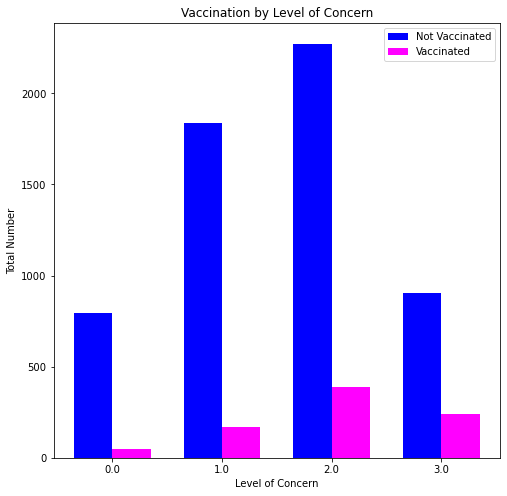

In [156]:
#plot it
level_concern = vacc_concern.index

fig, ax = plt.subplots(figsize=(8,8))
bar_width = 0.35

index = range(len(not_vacc_concern))
x_not_vaccinated = [i - bar_width/2 for i in index]
x_vaccinated = [i + bar_width/2 for i in index]


ax.bar(x=x_not_vaccinated, height=not_vacc_concern['preds'].values, 
       label='Not Vaccinated', width=bar_width, color='blue')

ax.bar(x=x_vaccinated, height=vacc_concern['preds'].values, 
       label='Vaccinated', width=bar_width, color='magenta')

ax.set_xlabel('Level of Concern')
ax.set_ylabel('Total Number')
ax.set_title('Vaccination by Level of Concern')
ax.set_xticks(index)
ax.set_xticklabels(level_concern)
ax.legend()
plt.show();

According to the data dictionary, 0 is the lowest level of concern, and 3 is very concerned. It makes sense that those who are not at all concerned (0) have a low level of vaccination. The more concerned about the virus, the more vaccination tends to increase. 

I think our three recommendations are pretty good. 

### Conclusion and Recommendations

This project aimed to build a predictive model that can predict whether someone has recieved the H1N1 flu vaccine. The goal in mind was to provide guidance to a public health official (such as the leadership team of the CDC) to help with any future health outbreaks or concerns. The dataset contained nearly 27,000 survey responses (the survey having been conducted as a random phone survey). I started with exploring the relationships between the variables, picked H1N1 as the target, and built several models. I chose to prioritize precision over recall, which aimed to minimize false positives, as I felt that had bigger health consequences. My final model was a simple logistic regression that had an accuracy of 84%, precision of 71%, recall of 43%, and F1 score of 53%. 

Here are my final recommendations: 

**1. Have doctors encourage vaccinations:** when doctors don't recommend getting the vaccine, there were much higher counts of unvaccinated people, whereas when doctors did recommend getting the vaccine, vaccination counts outnumbered the unvaccinated. People listen to their doctors!

**2. Spread correct information relating to the H1N1 flu:** the more knowledge people had about the virus, the higher the vaccination counts. If we can spread (correct!) information about the virus, it follows suit that more people would get vaccinated. 

**3. Find ways to connect with and encourage vaccinations in males aged 18-44:** those who identify as male aged 18-44 had the lowest counts of vaccination among any other sex/age combination. Females in general had higher counts of vaccination, with those 65+ having the highest. We need to find ways to encourage young males to get vaccinated. 

Implications for the stakeholder include increasing vaccination counts, which is a key part of achieving herd immunity. With any contagious (or otherwise) disease, herd immunity is a great goal as it means a large enough percent of the population has antibodies to the vaccine, which helps limit the spread of disease. 

### Next Steps

Next steps include: 

**1. Increase public awareness of the virus:** the more correct knowledge there is, the better. If we could find ways to increase knowledge and awareness of the virus and the vaccine, the more likely it seems that people will get vaccinated. 

**2. Research marketing strategies:** we need to try and increase the vaccination rates, and the best way to do that is to spread awareness. Researching marketing strategies will yield an effective way to reach key demographics. 

**3. Collect more data:** this survey contained nearly 27,000 participants, but with more data, we could make more accurate predictions. I would also like to explore the idea of completing a new survey, since this was from 2009. I'm curious to see how the COVID-19 pandemic has changed this data. 